
# Gen-Toolbox data analyis notebook

This notebook is part of the gen-toolbox project, a comprehensive tool designed for collating large numbers of VCF files from unique samples, annotating variants, and creating variant frequency tables. The project is tailored to run on substantial servers and has been spearheaded by the Tartu University Hospital Centre of Medical Genetics and the Tartu University Institute of Clinical Medicine, with the backing of the Estonian Research Council grant PSG774.

## Notebook Objective:

This particular notebook delves into the statistical analysis of Single Nucleotide Variants (SNVs) in genomic data. The aim is to:

- Load and process the combined frequency tables created from a large number of (g)VCF samples with the main Hail wrapper.
- Compute statistical metrics and burden ratios.
- Visualize results for a graphical analysis of the data.

## Prerequisites:

1. **Data Preparation**: Ensure you have the necessary VCF files and gene configurations. The notebook expects CSV or TSV formatted files.

2. **Environment Setup**: If using Docker, ensure Docker is installed and running. Alternatively, ensure you have a Python environment set up with all necessary libraries shown in requirements.txt. This Jupyter notebooks may have trouble with extremely large arrays. 

3. **Configuration**: Adjust path variables in the notebook to match the location of your data files. Jupyter notebooks detect data only from the same folder as the notebook itself (due to portability of notebooks)

### 0. Library Imports

In [87]:
import json
import pathlib
import re

import plotly.graph_objs
import scipy.stats as sp
from scipy import stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm 
import pylab as py

import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.stats import gaussian_kde
from scipy.stats import norm
import numpy as np
# Pandas version 1.24 required for hail, significant speed improvement in 2.0.X however
import pandas as pd
# Use modin as a pandas substitute for improved speeds
#import modin.pandas as pd
import firthlogist

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px

### 1. Input variables

#### 1.1 Path variables - change these for specifing correct paths

In [88]:
gene_config = pathlib.Path("../src/config/gene_config.json")
args_case =  "/mnt/sdb/results/frequency_table_639_LIHAS_positive_rarevariants.csv" # add here TSV or CSV file with case data
args_control = "/mnt/sdb/results/frequency_table_9059_LIHAS_negative_rarevariants.csv" # add here TSV or CSV file with control data

args_nullcase = "/mnt/sdb/nulldistribution_TSO/frequency_table_639_NULLDIST_positive.csv"
args_nullcontrol = "/mnt/sdb/nulldistribution_TSO/frequency_table_9059_NULLDIST_negative.csv"
out_dir = pathlib.Path("/mnt/sdb/tmp3/") 

#### 1.2 Configuration variables

In [89]:
is_csv = True # if False, then tsv, if True, then csv
drop_modifier = True
iterations = 1000000 # number of iterations for permutation test
combination_length= 10# number of genes in a set
case_genes_length = 10  #maximum number of 0s or near-zeros after epsilon correction allowed per set i.e. [0+ε 0+ε 0+ε 0+ε 0+ε 1+ε] vs [0+ε 0+ε# 1+ε 4+ε 5+ε 2+ε]
epsilon = 0.01  # A small value to be added to avoid division by null, will skew absolute burden ratios but retain the direction of ratios (GLOBAL)
min_burden_per_bin = 1

## 2. Utility functions

In [90]:
def load_gene_config(json_file):
    """Load gene configuration from a JSON file."""
    p = pathlib.Path(json_file)
    config = json.loads(p.read_bytes())
    return config

In [91]:
from pathlib import Path


def extract_number_from_filename(filepath: str) -> int:
    """Extract the number from the given filename."""
    filename = Path(filepath).name
    match = re.search(r"\d+", filename)
    return int(match.group()) if match else None

In [92]:
case_count = extract_number_from_filename(args_case) # extract number from filename
control_count = extract_number_from_filename(args_control) # extract number from filename

nullcase_count = extract_number_from_filename(args_nullcase) # extract number from filename
nullcontrol_count = extract_number_from_filename(args_nullcontrol) # extract number from filename
out_dir = out_dir.joinpath(f"iters_{iterations}_combs_{combination_length}_case_{case_count}_control_{control_count}")
out_dir.mkdir(parents=True, exist_ok=True) #Create a unique output directory for all outputs
print(f"Pheno case:control is {case_count}:{control_count}\nNulll case:control count is {nullcase_count}:{nullcontrol_count}")

Pheno case:control is 639:9059
Nulll case:control count is 639:9059



## 3. Data Loading

### 3.1 Loading Gene config

In [93]:
config = load_gene_config(gene_config)

In [94]:
# keys in gene_config would show information present in it
config.keys()

dict_keys(['store_data', 'intersect_genes_tso', 'intersect_genes_tshc', 'neg_control_genes', 'rv_genes', 'NMD_genes'])

In [95]:
# Lets Show some of itersect genes
config['intersect_genes_tso'][:5]

['A2M', 'A4GALT', 'A4GNT', 'AAAS', 'AADAC']

In [96]:
# How many intersect genes are there
len(config['intersect_genes_tso'])

4811

In [97]:
# printing number of genes in each conf
for conf in [config["intersect_genes_tso"], config["intersect_genes_tshc"], config["NMD_genes"]]:
    print(len(conf))

4811
79
275


In [98]:
nmd_gene_list = config["NMD_genes"] # Use .get for safety if key might be missing

### 3.2 Getting phenotype case/control and Null cohort case/control datasets

### 3.3 Loading case and control MAC data

For csv data file intersect_genes_tso is loaded while for tsv intersect_genes_tshc is loaded. Read the docs for clarification

In [99]:
if is_csv:
    intersect_genes = config["intersect_genes_tso"]
    df_case = pd.read_csv(args_case, sep=",", header=0)
    df_control = pd.read_csv(args_control, sep=",", header=0)
    
    df_nullcase = pd.read_csv(args_nullcase, sep=",", header=0)
    df_nullcontrol = pd.read_csv(args_nullcontrol, sep=",", header=0)
else:
    intersect_genes = config["intersect_genes_tshc"]
    df_case = pd.read_table(args_case, sep="\t", header=0)
    df_control = pd.read_table(args_control, sep="\t", header=0)
    
    df_nullcase = pd.read_table(args_nullcase, sep="\t", header=0)
    df_nullcontrol = pd.read_table(args_nullcontrol, sep="\t", header=0)

In [100]:
def drop_columns_containing_substring(df: pd.DataFrame, substring_to_drop: str = "MODIFIER") -> pd.DataFrame:
    """
    Drops all columns from a DataFrame where the column name contains a specified substring (case-insensitive).

    Args:
        df: The input pandas DataFrame.
        substring_to_drop: The substring to search for in column names. Defaults to "MODIFIER".

    Returns:
        A new pandas DataFrame with the specified columns dropped.
        Returns the original DataFrame if no columns match the criteria.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
    if not isinstance(substring_to_drop, str):
        raise TypeError("substring_to_drop must be a string.")

    # Ensure substring is uppercase for case-insensitive comparison
    substring_upper = substring_to_drop.upper()

    # Identify columns to drop
    cols_to_drop = [
        col for col in df.columns
        if isinstance(col, str) and substring_upper in col.upper()
    ]

    if not cols_to_drop:
        print(f"No columns found containing '{substring_to_drop}'. DataFrame remains unchanged.")
        return df.copy() # Return a copy to maintain consistency of returning a new df

    print(f"Dropping columns: {cols_to_drop}")
    df = df.drop(columns=cols_to_drop) # Drop columns
    df = df[~(df.iloc[:, 1:] == 0).all(axis=1)] # Now drop rows if every col == 0, artefact of dropping MODIFIER cols
    return df

In [101]:
if drop_modifier:
    df_case, df_control, df_nullcase, df_nullcontrol = map(
        lambda df: drop_columns_containing_substring(df), [df_case, df_control, df_nullcase, df_nullcontrol])
df_case.head(2)

Dropping columns: ['MODIFIER.gnomad_001', 'MODIFIER.gnomad_001_01', 'MODIFIER.gnomad_01_1']
Dropping columns: ['MODIFIER.gnomad_001', 'MODIFIER.gnomad_001_01', 'MODIFIER.gnomad_01_1']
Dropping columns: ['MODIFIER.gnomad_001', 'MODIFIER.gnomad_001_01', 'MODIFIER.gnomad_01_1']
Dropping columns: ['MODIFIER.gnomad_001', 'MODIFIER.gnomad_001_01', 'MODIFIER.gnomad_01_1']


,Unnamed: 0,HIGH.gnomad_001,HIGH.gnomad_001_01,HIGH.gnomad_01_1,MODERATE.gnomad_001,MODERATE.gnomad_001_01,MODERATE.gnomad_01_1,LOW.gnomad_001,LOW.gnomad_001_01,LOW.gnomad_01_1
0,A4GNT,0,0,4,0,3,6,0,0,6
1,AADAC,0,0,8,1,1,7,0,0,0


In [102]:
# Dataframe length
# Each row contains a gene
print(f'number of genes in case: {len(df_case)}', f'number of genes in control: {len(df_control)}\n' +
f'number of genes in case: {len(df_nullcase)}', f'number of genes in control: {len(df_nullcontrol)}')

number of genes in case: 6179 number of genes in control: 11174
number of genes in case: 6186 number of genes in control: 11295


### 3.4 Assigning the 1st column the name of gene

In [103]:
df_case.rename(columns={df_case.columns[0]: "gene"}, inplace = True)
df_case["total_burden"] = df_case.iloc[:, 1:].sum(axis=1)
df_control.rename(columns={df_control.columns[0]: "gene"}, inplace = True)
df_control["total_burden"] = df_control.iloc[:, 1:].sum(axis=1)

df_nullcase.rename(columns={df_nullcase.columns[0]: "gene"}, inplace = True)
df_nullcase["total_burden"]=df_nullcase.iloc[:, 1:].sum(axis=1)
df_nullcontrol.rename(columns={df_nullcontrol.columns[0]: "gene"}, inplace = True)
df_nullcontrol["total_burden"]=df_nullcontrol.iloc[:, 1:].sum(axis=1)

In [104]:
bin_columns = df_case.columns.drop("gene")
bin_columns

Index(['HIGH.gnomad_001', 'HIGH.gnomad_001_01', 'HIGH.gnomad_01_1',
       'MODERATE.gnomad_001', 'MODERATE.gnomad_001_01', 'MODERATE.gnomad_01_1',
       'LOW.gnomad_001', 'LOW.gnomad_001_01', 'LOW.gnomad_01_1',
       'total_burden'],
      dtype='object')

### 3.5 Getting list of all genes

In [105]:
all_genes = df_case['gene']

## 4. Cleaning data

### 4.1 Selecting intersect gene from config

### 4.2 Taking intersect of both data frames and sorting on gene column

This step is performed to ensure that same genes for case and control are present and we can apply indexwise operation in our statistical test. Randomly selected indices will produce same genes from both data frames.

Sorting is done because if we select gene names randomly and then filter both dataframes for selected gene names then it will be a slow process


In [106]:
def prepare_gene_intersection(case, control, nullcase, nullcontrol, intersect_genes=None):
    """
    Filters and aligns df_case, df_control, df_nullcase, and df_nullcontrol on the same set of genes.
    
    Parameters:
    - df_case, df_control: real case and control dataframes
    - df_nullcase, df_nullcontrol: null simulation case/control dataframes
    - intersect_genes: optional list/set of genes to restrict to
    
    Returns:
    - df_case, df_control, df_nullcase, df_nullcontrol: all aligned on same genes
    """
    # Drop empty gene entries first
    for df in [case, control, nullcase, nullcontrol]:
        df.dropna(subset=["gene"], inplace=True)

    # Apply external intersect if provided
    if intersect_genes is not None:
        case = case[case.gene.isin(intersect_genes)]
        control = control[control.gene.isin(intersect_genes)]
        nullcase = nullcase[nullcase.gene.isin(intersect_genes)]
        nullcontrol = nullcontrol[nullcontrol.gene.isin(intersect_genes)]

    # Compute actual intersection across all four dataframes
    genes_intersection = set(case['gene']) & set(control['gene']) \
                         & set(nullcase['gene']) & set(nullcontrol['gene'])

    # Filter and sort all dataframes
    def filter_and_sort(df):
        df = df[df['gene'].isin(genes_intersection)].copy()
        df = df.sort_values('gene').fillna(0)
        df.reset_index(drop=True, inplace=True)
        return df

    case = filter_and_sort(case)
    control = filter_and_sort(control)
    nullcase = filter_and_sort(nullcase)
    nullcontrol = filter_and_sort(nullcontrol)

    # Final check
    assert case['gene'].equals(control['gene']) and \
           case['gene'].equals(nullcase['gene']) and \
           case['gene'].equals(nullcontrol['gene']), \
           "DataFrames are not aligned by gene!"
    print(f"Total number of genes in intersect is {len(case['gene'])}")
    
    return case, control, nullcase, nullcontrol


In [107]:
df_case, df_control, df_nullcase, df_nullcontrol = prepare_gene_intersection(
    df_case, df_control, df_nullcase, df_nullcontrol, intersect_genes=intersect_genes
)

Total number of genes in intersect is 4231


In [108]:
print(df_case)

        gene  HIGH.gnomad_001  HIGH.gnomad_001_01  HIGH.gnomad_01_1  \
0        A2M                0                   0                 0   
1     A4GALT                0                   0                 0   
2      A4GNT                0                   0                 4   
3       AAAS                0                   0                 0   
4      AADAC                0                   0                 8   
...      ...              ...                 ...               ...   
4226   ZNF81                0                   0                 0   
4227  ZNHIT6                0                   0                 0   
4228   ZNRF1                0                   0                 0   
4229    ZPBP                0                   0                 0   
4230   ZPBP2                0                   0                 0   

      MODERATE.gnomad_001  MODERATE.gnomad_001_01  MODERATE.gnomad_01_1  \
0                       2                       2                     7 

## 5. Statistical test

### 5.1 Single gene burden statistics
Difference in burden between the phenotype and null cohorts with log2 fold change, greater change means greater burden in phenotype vs null.
Minimum cutoff MAC > 5.

In [109]:
def analyze_bins(_case, _control, _nullcase, _nullcontrol, _bin_columns, min_mac=case_genes_length):
    """
    Analyze bins and calculate log2 fold changes for given dataframes, with at least 

    Parameters:
        df_case (pd.DataFrame): DataFrame containing case data.
        df_control (pd.DataFrame): DataFrame containing control data.
        df_nullcase (pd.DataFrame): DataFrame containing null case data.
        df_nullcontrol (pd.DataFrame): DataFrame containing null control data.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        pd.DataFrame: DataFrame with ranking results.
    """

    ranking_results = []

    for bin_name in _bin_columns:
        print(f"\nAnalyzing bin: {bin_name}")

        pheno_ratios, null_ratios, genes = [], [], []
        case_burdens, control_burdens, nullcase_burdens, nullcontrol_burdens = [], [], [], []

        for idx, gene in enumerate(df_case["gene"]):
            case_val = df_case.loc[idx, bin_name]
            control_val = df_control.loc[idx, bin_name]
            nullcase_val = df_nullcase.loc[idx, bin_name]
            nullcontrol_val = df_nullcontrol.loc[idx, bin_name]
            pheno_ratio = np.divide(case_val, control_val, out=np.array(np.nan, dtype=float), where=(control_val >= min_mac) & (case_val >= min_mac))
            null_ratio = np.divide(nullcase_val, nullcontrol_val, out=np.array(np.nan, dtype=float), where=(nullcontrol_val >= min_mac) & (nullcase_val >= min_mac))

            pheno_ratios.append(pheno_ratio)
            null_ratios.append(null_ratio)
            genes.append(gene)
            case_burdens.append(case_val)
            control_burdens.append(control_val)
            nullcase_burdens.append(nullcase_val)
            nullcontrol_burdens.append(nullcontrol_val)

        valid_mask = np.isfinite(pheno_ratios) & np.isfinite(null_ratios)
        pheno_ratios, null_ratios, genes = np.array(pheno_ratios)[valid_mask], np.array(null_ratios)[valid_mask], np.array(genes)[valid_mask]
        case_burdens, control_burdens = np.array(case_burdens)[valid_mask], np.array(control_burdens)[valid_mask]
        nullcase_burdens, nullcontrol_burdens = np.array(nullcase_burdens)[valid_mask], np.array(nullcontrol_burdens)[valid_mask]

        print(f"  {valid_mask.sum()} valid genes in bin {bin_name}: {genes}")

        log2_fold_changes = np.log2(np.divide(pheno_ratios, null_ratios, out=np.full_like(pheno_ratios, np.nan), where=null_ratios != 0))

        for g, case_b, control_b, nullcase_b, nullcontrol_b, p_ratio, n_ratio, log2fc in zip(genes, case_burdens, control_burdens, nullcase_burdens, nullcontrol_burdens, pheno_ratios, null_ratios, log2_fold_changes):
            #if np.isnan(log2fc) or np.isinf(log2fc):
            #    continue

            ranking_results.append({
                "gene": g,
                "bin": bin_name,
                "case_burden": case_b,
                "control_burden": control_b,
                "nullcase_burden": nullcase_b,
                "nullcontrol_burden": nullcontrol_b,
                "pheno_ratio": float(p_ratio),
                "null_ratio": float(n_ratio),
                "log2_fold_change": float(log2fc)
            })

    foldchange_df = pd.DataFrame(ranking_results).sort_values(by=["log2_fold_change", "case_burden"], ascending=[False, False])

    print("\nTop 20 fold-changes:")
    print(foldchange_df[["gene", "bin", "log2_fold_change", "case_burden", "control_burden", "nullcase_burden", "nullcontrol_burden"]].head(20))

    return foldchange_df

# Example usage
foldchange_df = analyze_bins(df_case, df_control, df_nullcase, df_nullcontrol, bin_columns)



Analyzing bin: HIGH.gnomad_001
  4 valid genes in bin HIGH.gnomad_001: ['BCR' 'FANCD2' 'HLA-DRB1' 'HLA-DRB5']

Analyzing bin: HIGH.gnomad_001_01
  3 valid genes in bin HIGH.gnomad_001_01: ['HLA-DRB5' 'PSPH' 'TAS2R19']

Analyzing bin: HIGH.gnomad_01_1
  15 valid genes in bin HIGH.gnomad_01_1: ['ABCA7' 'BTN2A1' 'CAMP' 'FANCD2' 'GJB2' 'HLA-DRB5' 'KRT83' 'LTK'
 'MAP3K15' 'MS4A12' 'OBSCN' 'OBSL1' 'TP53I3' 'ZAN' 'ZNF674']

Analyzing bin: MODERATE.gnomad_001
  26 valid genes in bin MODERATE.gnomad_001: ['ADAMTSL2' 'ALMS1' 'ANK2' 'BCR' 'CUBN' 'DNM2' 'HLA-DPB1' 'HLA-DRB5'
 'HYDIN' 'KIR2DL1' 'KIR2DL3' 'KIR2DL4' 'KIR3DL1' 'KRT18' 'NEB' 'OBSCN'
 'PCNT' 'PKD1' 'PLEC' 'SELPLG' 'SYNE1' 'SYNE2' 'TAS2R19' 'TROAP' 'TTN'
 'VCAN']

Analyzing bin: MODERATE.gnomad_001_01
  74 valid genes in bin MODERATE.gnomad_001_01: ['ABCA13' 'ACACB' 'APOB' 'ATM' 'CABIN1' 'CATSPER1' 'COL6A3' 'COL6A5'
 'COL7A1' 'DLGAP3' 'DNAH11' 'DNAH5' 'DYNC2H1' 'FBN3' 'FLG' 'FRG1' 'FSCB'
 'HEPACAM' 'HERC2' 'HLA-DRB1' 'HLA-DRB5' 'HSPG2' 

In [110]:
def find_infinite_pheno_genes(_case, _control, bin_columns, tag, keyword="all"):
    """
    Find genes where in the phenotype cohort:
    - Case burden > 0
    - Control burden == 0
    in bins matching a keyword (e.g., "HIGH") or default all.

    Args:
        df_case: DataFrame with case burdens.
        df_control: DataFrame with control burdens.
        bin_columns: List of burden columns (exclude "gene" column).
        keyword: Keyword to select bins (default "HIGH").

    Returns:
        DataFrame listing genes with infinite ratios i.e. singleton mutations (phenotype-enforcing unidirectional effect)
    """
    if keyword == "all":
        selected_bins = [col for col in bin_columns]
    else:
        # Find bins matching keyword
        selected_bins = [col for col in bin_columns if keyword.upper() in col.upper()]
    print(f"Selected bins for keyword '{keyword}': {selected_bins}")
    print(_control[_control["total_burden"] == 0])
    infinite_genes = []

    for bin_name in selected_bins:
        for idx, gene in enumerate(_case["gene"]):
            case_val = _case.loc[idx, bin_name]
            control_val = _control.loc[idx, bin_name]

            # Condition for infinite ratio
            if control_val == 0 and case_val >= 3:
                infinite_genes.append({
                    "gene": gene,
                    "bin": bin_name,
                    "case_burden": case_val,
                    "control_burden": control_val,
                    "ratio_status": np.inf
                })
            # elif control_val > 0 and case_val == 0:
            #     infinite_genes.append({
            #         "gene": gene,
            #         "bin": bin_name,
            #         "case_burden": case_val,
            #         "control_burden": control_val,
            #         "ratio_status": -np.inf
            #     })
                

    # Create DataFrame
    infinite_df = pd.DataFrame(infinite_genes)

    print(f"{tag}: found {len(infinite_df)} genes with infinite pheno burden ratio in '{keyword}' bins.")
    if len(infinite_df) > 0:
        print(infinite_df)
        return infinite_df.sort_values(by=["gene", "bin", "ratio_status"], ascending=[False, False, False], na_position='first')
    else:
        return infinite_df


find_infinite_pheno_genes(df_case, df_control, bin_columns, "Pheno")
find_infinite_pheno_genes(df_nullcase, df_nullcontrol, bin_columns, "Null")


Selected bins for keyword 'all': ['HIGH.gnomad_001', 'HIGH.gnomad_001_01', 'HIGH.gnomad_01_1', 'MODERATE.gnomad_001', 'MODERATE.gnomad_001_01', 'MODERATE.gnomad_01_1', 'LOW.gnomad_001', 'LOW.gnomad_001_01', 'LOW.gnomad_01_1', 'total_burden']
Empty DataFrame
Columns: [gene, HIGH.gnomad_001, HIGH.gnomad_001_01, HIGH.gnomad_01_1, MODERATE.gnomad_001, MODERATE.gnomad_001_01, MODERATE.gnomad_01_1, LOW.gnomad_001, LOW.gnomad_001_01, LOW.gnomad_01_1, total_burden]
Index: []
Pheno: found 2 genes with infinite pheno burden ratio in 'all' bins.
      gene                  bin  case_burden  control_burden  ratio_status
0     KLF6  MODERATE.gnomad_001            3               0           inf
1  TACSTD2       LOW.gnomad_001            3               0           inf
Selected bins for keyword 'all': ['HIGH.gnomad_001', 'HIGH.gnomad_001_01', 'HIGH.gnomad_01_1', 'MODERATE.gnomad_001', 'MODERATE.gnomad_001_01', 'MODERATE.gnomad_01_1', 'LOW.gnomad_001', 'LOW.gnomad_001_01', 'LOW.gnomad_01_1', 'total_b

""


### 5.2 Z-test for difference in proportions test per gene per bin for the phenotype cohort
FDR correction applied. This would be the discovery set for genes with a possible monogenic burden. Prints the genes and bins with a significant p-value, shows the odds ratio.
E.g.

| gene  | case_burden | control_burden | odds_ratio | pval_fisher  | fdr_pval    | significant_fdr | bin               |
|-------|-------------|----------------|------------|--------------|-------------|-----------------|-------------------|
| CAPN3 | 13.0        | 26.0           | 7.214856   | 6.424472e-07 | 2.804924e-03| True            | HIGH.gnomad_001_01|
| FRG1  | 433.0       | 5071.0         | 1.653036   | 2.503832e-09 | 1.093173e-05| True            | MODERATE.gnomad_001_01|



In [111]:
def run_ztest_two_proportions_volcano(
    df_case_pheno, df_case_null,
    n_indiv_case_pheno, n_indiv_case_null,
    bin_columns_list,
    cohort_name="Z-test Case Proportions",
    mac_threshold_case_pheno=5,
    mac_threshold_case_null=5,
    p_value_threshold_alpha=0.05
):
    results = []

    n_alleles_case_pheno = 2 * n_indiv_case_pheno
    n_alleles_case_null = 2 * n_indiv_case_null

    for gene_idx in df_case_pheno.index:
        gene_name = df_case_pheno.loc[gene_idx, 'gene']

        for bin_base in bin_columns_list:
            ac_case_pheno = df_case_pheno.loc[gene_idx, bin_base]
            ac_case_null = df_case_null.loc[gene_idx, bin_base]

            if (ac_case_pheno < mac_threshold_case_pheno) or (ac_case_null < mac_threshold_case_null):
                continue

            p1 = ac_case_pheno / n_alleles_case_pheno
            p2 = ac_case_null / n_alleles_case_null

            pooled_p = (ac_case_pheno + ac_case_null) / (n_alleles_case_pheno + n_alleles_case_null)
            se = np.sqrt(pooled_p * (1 - pooled_p) * (1 / n_alleles_case_pheno + 1 / n_alleles_case_null))

            if se == 0 or np.isnan(se):
                z_score = np.nan
                pval = np.nan
            else:
                z_score = (p1 - p2) / se
                pval = 2 * norm.sf(np.abs(z_score))

            effect_size = p1 - p2

            results.append({
                'gene': gene_name,
                'bin': bin_base,
                'ac_case_pheno': ac_case_pheno,
                'ac_case_null': ac_case_null,
                'p1_pheno': p1,
                'p2_null': p2,
                'effect_size': effect_size,
                'z_score': z_score,
                'p_val': pval
            })

    results_df = pd.DataFrame(results).dropna()

    if results_df.empty:
        print("⚠️ No valid results for Z-test. Check thresholds or input.")
        return results_df

    # Multiple testing corrections
    reject_bonf, pval_bonf, _, alphacBonf = multipletests(results_df['p_val'], method='fdr_tsbh', alpha=p_value_threshold_alpha)
    results_df['pval_bonferroni'] = pval_bonf
    results_df['significant_bonferroni'] = reject_bonf
    results_df['-log10_pval_bonferroni'] = -np.log10(results_df['pval_bonferroni'].replace(0, np.nextafter(0, 1)))

    # Plot
    plt.figure(figsize=(14, 10))
    plt.scatter(results_df["effect_size"], results_df["-log10_pval_bonferroni"], alpha=0.5, s=15, color='gray')

    # Highlight significant hits
    significant = results_df[results_df["significant_bonferroni"] == True]
    if not significant.empty:
        plt.scatter(significant["effect_size"], significant["-log10_pval_bonferroni"],
                    color="red", s=50, edgecolor='black', zorder=3, label='Significant (Bonf.)')

        # Top genes labeling
        top_n = 20
        top_hits = significant.sort_values("-log10_pval_bonferroni", ascending=False).head(top_n)
        texts = []
        legend_entries = []
        for i, (_, row) in enumerate(top_hits.iterrows(), start=1):
            texts.append(plt.text(row["effect_size"], row["-log10_pval_bonferroni"], str(i),
                                  fontsize=8, ha='center', va='bottom', fontweight='bold'))
            legend_entries.append(f"{i}: {row['gene']} ({row['bin']})")

        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

        # Custom legend
        plt.legend(
            [plt.Line2D([0], [0], marker='o', color='w', label=entry, markersize=5, markerfacecolor='red')
             for entry in legend_entries],
            legend_entries,
            loc='upper right',
            fontsize=8,
            title="Top Genes (Numbered)"
        )

    # Reference lines
    plt.axvline(0, color='black', linestyle='--', alpha=0.7)
    plt.axhline(-np.log10(p_value_threshold_alpha), color='blue', linestyle='--')

    plt.xlabel("Effect Size (Δ allele proportion case)", fontsize=12)
    plt.ylabel("-Log10 Bonferroni P-value", fontsize=14)
    plt.title(f"Volcano Plot: Case Proportion Difference ({cohort_name})", fontsize=14)
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

    return results_df

In [112]:
def run_ztest_diff_of_diffs_volcano(
    df_case_pheno, df_control_pheno, df_case_null, df_control_null,
    n_indiv_case_pheno, n_indiv_control_pheno, n_indiv_case_null, n_indiv_control_null,
    bin_columns_list, # Pass the filtered list of bin columns
    cohort_name="Comparison", 
    mac_threshold_gene_pheno=5, # Min total MAC for a gene in phenotype cohort to be included
    mac_threshold_gene_null=5,   # Min total MAC for a gene in null cohort to be included
    p_value_threshold_alpha=0.05
):
    results = []
    rejects = []

    n_alleles_case_pheno = 2 * n_indiv_case_pheno
    n_alleles_control_pheno = 2 * n_indiv_control_pheno
    n_alleles_case_null = 2 * n_indiv_case_null
    n_alleles_control_null = 2 * n_indiv_control_null
    for gene_idx in df_case_pheno.index: # Iterate through genes (assuming aligned indices)
        gene_name = df_case_pheno.loc[gene_idx, 'gene']

        for bin_base in bin_columns_list: # Iterate through your filtered bin columns
            # Allele Counts (AC)
            ac_case_pheno = df_case_pheno.loc[gene_idx, bin_base]
            ac_control_pheno = df_control_pheno.loc[gene_idx, bin_base]
            ac_case_null = df_case_null.loc[gene_idx, bin_base]
            ac_control_null = df_control_null.loc[gene_idx, bin_base]

            # Apply MAC threshold for the gene in this bin for both cohorts
            if (ac_case_pheno + ac_control_pheno < mac_threshold_gene_pheno) or \
               (ac_case_null + ac_control_null < mac_threshold_gene_null):
                rejects.append([gene_name, bin_base])
                continue

            # Proportions
            p_case_pheno = ac_case_pheno / n_alleles_case_pheno
            p_control_pheno = ac_control_pheno / n_alleles_control_pheno
            p_case_null = ac_case_null / n_alleles_case_null
            p_control_null = ac_control_null / n_alleles_control_null

            # Differences in proportions
            delta_p_pheno = p_case_pheno - p_control_pheno
            delta_p_null = p_case_null - p_control_null

            # Variances of proportions
            var_p_case_pheno = p_case_pheno * (1 - p_case_pheno) / n_alleles_case_pheno
            var_p_control_pheno = p_control_pheno * (1 - p_control_pheno) / n_alleles_control_pheno
            var_p_case_null = p_case_null * (1 - p_case_null) / n_alleles_case_null
            var_p_control_null = p_control_null * (1 - p_control_null) / n_alleles_control_null
            
            # Ensure variances are not negative (can happen with tiny p near 0 or 1 and small N)
            var_p_case_pheno = max(var_p_case_pheno, 0)
            var_p_control_pheno = max(var_p_control_pheno, 0)
            var_p_case_null = max(var_p_case_null, 0)
            var_p_control_null = max(var_p_control_null, 0)


            # Variance of differences
            var_delta_p_pheno = var_p_case_pheno + var_p_control_pheno
            var_delta_p_null = var_p_case_null + var_p_control_null

            # Standard Error of the difference of differences
            se_total_diff = np.sqrt(var_delta_p_pheno + var_delta_p_null)

            if se_total_diff == 0 or np.isnan(se_total_diff):
                z_score = np.nan
                pval = np.nan
            else:
                estimate_diff_of_diffs = delta_p_pheno - delta_p_null
                z_score = estimate_diff_of_diffs / se_total_diff
                pval = 2 * norm.sf(np.abs(z_score)) # Two-tailed p-value

            # Effect size for volcano plot (difference of differences in proportions)
            effect_size = delta_p_pheno - delta_p_null
            
            # Alternative effect size: log2 ratio of odds ratios (more complex to calculate SE for Z)
            # OR_pheno = ((p_case_pheno + epsilon) / (1 - p_case_pheno + epsilon)) / \
            #            ((p_control_pheno + epsilon) / (1 - p_control_pheno + epsilon))
            # OR_null = ((p_case_null + epsilon) / (1 - p_case_null + epsilon)) / \
            #           ((p_control_null + epsilon) / (1 - p_control_null + epsilon))
            # log2_or_ratio_effect = np.log2((OR_pheno + epsilon) / (OR_null + epsilon))


            results.append({
                'gene': gene_name,
                'bin': bin_base,
                'ac_case_pheno': ac_case_pheno,
                'ac_control_pheno': ac_control_pheno,
                'ac_case_null': ac_case_null,
                'ac_control_null': ac_control_null,
                'delta_p_pheno': delta_p_pheno,
                'delta_p_null': delta_p_null,
                'effect_size_diff_of_diffs': effect_size,
                'z_score': z_score,
                'p_val': pval,
            })

    if not results:
        print("No results generated. Check MAC thresholds and data.")
        return pd.DataFrame()

    results_df = pd.DataFrame(results)

    results_df.dropna(subset=['p_val'], inplace=True) # Drop rows where p-value couldn't be calculated

    if results_df.empty:
        print("No results with valid p-values.")
        return results_df

    # Multiple test correction (across all gene-bin tests)
    reject_bonf, pval_bonferroni, alphacSidak, alphacBonf = multipletests(results_df['p_val'], method='bonferroni', alpha=p_value_threshold_alpha)
    results_df['pval_bonferroni'] = pval_bonferroni
    results_df['significant_bonferroni'] = reject_bonf
    results_df["-log10_pval_bonferroni"] = -np.log10(results_df["pval_bonferroni"])
    print(results_df['significant_bonferroni'])
    
        # --- MODIFICATION: Filter results to only include CAPN3 ---
    print(f"Original results_df_all_genes shape: {results_df.shape}")
    results_df_capn3 = results_df[results_df['gene'] == "CAPN3"].copy()
    print(f"Filtered results_df for CAPN3: {results_df_capn3}")

    if results_df_capn3.empty:
        print("No results found for gene CAPN3 after initial processing, MAC thresholds, and p-value calculation.")
     # --- Volcano Plot ---
    plt.figure(figsize=(14, 10)) 
    
    # Scatter all gene-bins
    plt.scatter(results_df["effect_size_diff_of_diffs"], 
                results_df["-log10_pval_bonferroni"], 
                alpha=0.5, s=15, color='grey', label="Other Gene-Bins") # Label for legend

    # Highlight significant gene-bins
    significant_hits = results_df[results_df["significant_bonferroni"] == True]
    
    legend_handles_plot = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=7, label='Other Gene-Bins')]
    legend_labels_plot = ['Other Gene-Bins']

    if not significant_hits.empty:
        plt.scatter(significant_hits["effect_size_diff_of_diffs"], 
                    significant_hits["-log10_pval_bonferroni"], 
                    color="red", s=50, edgecolor='black', zorder=3, label=f'Significant (Bonf. p < {alphacBonf})') # Add label here
        legend_handles_plot.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label=f'Significant (Bonf. p < {alphacBonf})'))
        legend_labels_plot.append(f'Significant (Bonf. p < {alphacBonf})')

        top_n = 20
        top_hits_to_label = significant_hits.sort_values(
            by=["-log10_pval_bonferroni", "effect_size_diff_of_diffs"], 
            key=lambda x: x.abs() if x.name == "effect_size_diff_of_diffs" else x, 
            ascending=[False, False] 
        ).head(top_n)
        
        texts = []
        legend_entries_for_top_hits_list = [] 
        
        if not top_hits_to_label.empty:
            # Plot top hits with a distinct marker, but don't add a separate legend item for "Top N Hits" yet
            plt.scatter(top_hits_to_label["effect_size_diff_of_diffs"], 
                        top_hits_to_label["-log10_pval_bonferroni"], 
                        color="darkorange", s=70, edgecolor='black', zorder=5, label=f'Top {len(top_hits_to_label)} Labeled Hits') # Add label
            legend_handles_plot.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', markersize=7, label=f'Top {len(top_hits_to_label)} Labeled Hits'))
            legend_labels_plot.append(f'Top {len(top_hits_to_label)} Labeled Hits')


            for i, (_, row) in enumerate(top_hits_to_label.iterrows(), start=1):
                texts.append(plt.text(row["effect_size_diff_of_diffs"], 
                                      row["-log10_pval_bonferroni"], 
                                      str(i), fontsize=8, ha='center', va='bottom', fontweight='bold', zorder=6))
                legend_entries_for_top_hits_list.append(f"{i}: {row['gene']} ({row['bin']})")
            if texts:
                adjust_text(texts, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
            
            print(f"\nTop {len(legend_entries_for_top_hits_list)} Labeled Gene-Bins (Numbered on Plot):")
            for entry_text in legend_entries_for_top_hits_list:
                print(entry_text)
            
            # Add individual top hit entries to the legend
            for entry_text in legend_entries_for_top_hits_list:
                # Using a minimal marker for text entries in legend
                legend_handles_plot.append(plt.Line2D([0], [0], marker='None', linestyle='None')) 
                legend_labels_plot.append(entry_text)
    
    # Bonferroni threshold line
    bonf_line_label_added = False
    if not results_df.empty and 'pval_bonferroni' in results_df.columns and results_df['pval_bonferroni'].notna().any():
        num_tests_performed = results_df['p_val'].notna().sum() 
        if num_tests_performed > 0: 
            log10_thresh = -np.log10(alphacBonf)
            plt.axhline(log10_thresh, color='blue', linestyle='--') # Label will be added to legend handles/labels
            legend_handles_plot.append(plt.Line2D([0], [0], color='blue', linestyle='--'))
            legend_labels_plot.append(f'Bonferroni α={p_value_threshold_alpha} (p={alphacBonf:.1e})') # Use .1e for scientific notation if small
            bonf_line_label_added = True

    plt.axvline(0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel("Effect Size: (Pheno ΔP) - (Null ΔP)", fontsize=12)
    plt.ylabel("-Log10 Bonferroni P-value (Z-test Diff-in-Diff)", fontsize=14)
    plt.title(f"Volcano: Diff-in-Diff of Allele Proportions ({cohort_name})", fontsize=14)
    plt.grid(True, linestyle=":", alpha=0.6)
    
    # Create the legend with all collected handles and labels
    if legend_handles_plot:
        plt.legend(handles=legend_handles_plot, labels=legend_labels_plot, 
                   loc='best', bbox_to_anchor=(1.02, 0.5), 
                   borderaxespad=0., title="Legend", fontsize=8)

    #plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend if it's outside
    plt.show()

    return results_df


/tmp/ipykernel_3799998/2331173752.py:29: RuntimeWarning:

invalid value encountered in sqrt



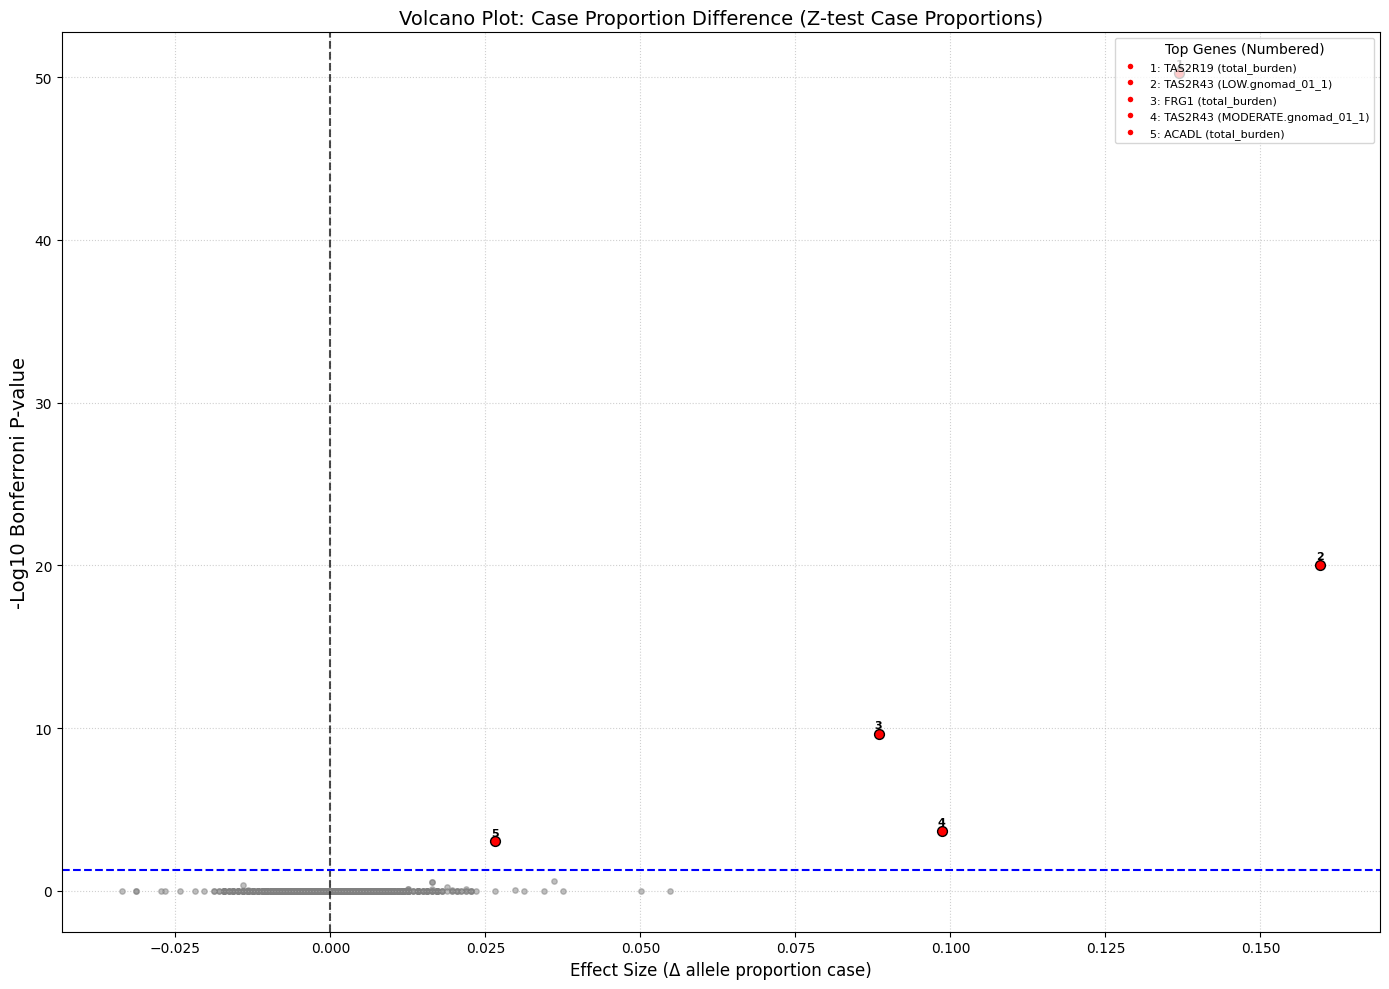


--- Top significant gene-bin differences (Pheno vs Null comparison) with Raw Allele Counts ---
No significant hits found after Bonferroni correction.


In [113]:
results_in_diff_df = run_ztest_two_proportions_volcano(df_case, df_nullcase, case_count, nullcase_count, bin_columns)
if results_in_diff_df is not None and not results_in_diff_df.empty:
    print("\n--- Top significant gene-bin differences (Pheno vs Null comparison) with Raw Allele Counts ---")
    
    # Filter for significant hits
    significant_hits_df = results_in_diff_df[results_in_diff_df['significant_bonferroni'] == "True"]
    
    if not significant_hits_df.empty:
        # Define the columns you want to see, including the raw counts
        columns_to_display = [
                'gene',
                'bin',
                'ac_case_pheno',
                'ac_case_null',
                'p1_pheno',
                'p2_null',
                'effect_size',
                'z_score',
                'p_val'
        ]
        
        # Ensure all requested columns exist in the DataFrame to avoid KeyErrors
        existing_cols_to_display = [col for col in columns_to_display if col in significant_hits_df.columns]
        
        # Sort and display the top N hits
        top_significant_hits_with_counts = significant_hits_df[existing_cols_to_display].sort_values(
            by="gene", ascending=False
        ).head(20)
        
        print(top_significant_hits_with_counts)
    else:
        print("No significant hits found after Bonferroni correction.")
else:
    print("No results were generated from the Z-test function, or the results DataFrame is empty.")

0        False
1        False
2        False
3        False
4        False
         ...  
29796    False
29797    False
29798    False
29799    False
29800    False
Name: significant_bonferroni, Length: 29799, dtype: bool
Original results_df_all_genes shape: (29799, 14)
Filtered results_df for CAPN3:        gene                     bin  ac_case_pheno  ac_control_pheno  \
3860  CAPN3         HIGH.gnomad_001              0                 3   
3861  CAPN3      HIGH.gnomad_001_01             13                26   
3862  CAPN3     MODERATE.gnomad_001             11                22   
3863  CAPN3  MODERATE.gnomad_001_01              4                28   
3864  CAPN3    MODERATE.gnomad_01_1              2                10   
3865  CAPN3          LOW.gnomad_001              1                33   
3866  CAPN3       LOW.gnomad_001_01              2                29   
3867  CAPN3         LOW.gnomad_01_1              6                45   
3868  CAPN3            total_burden             39

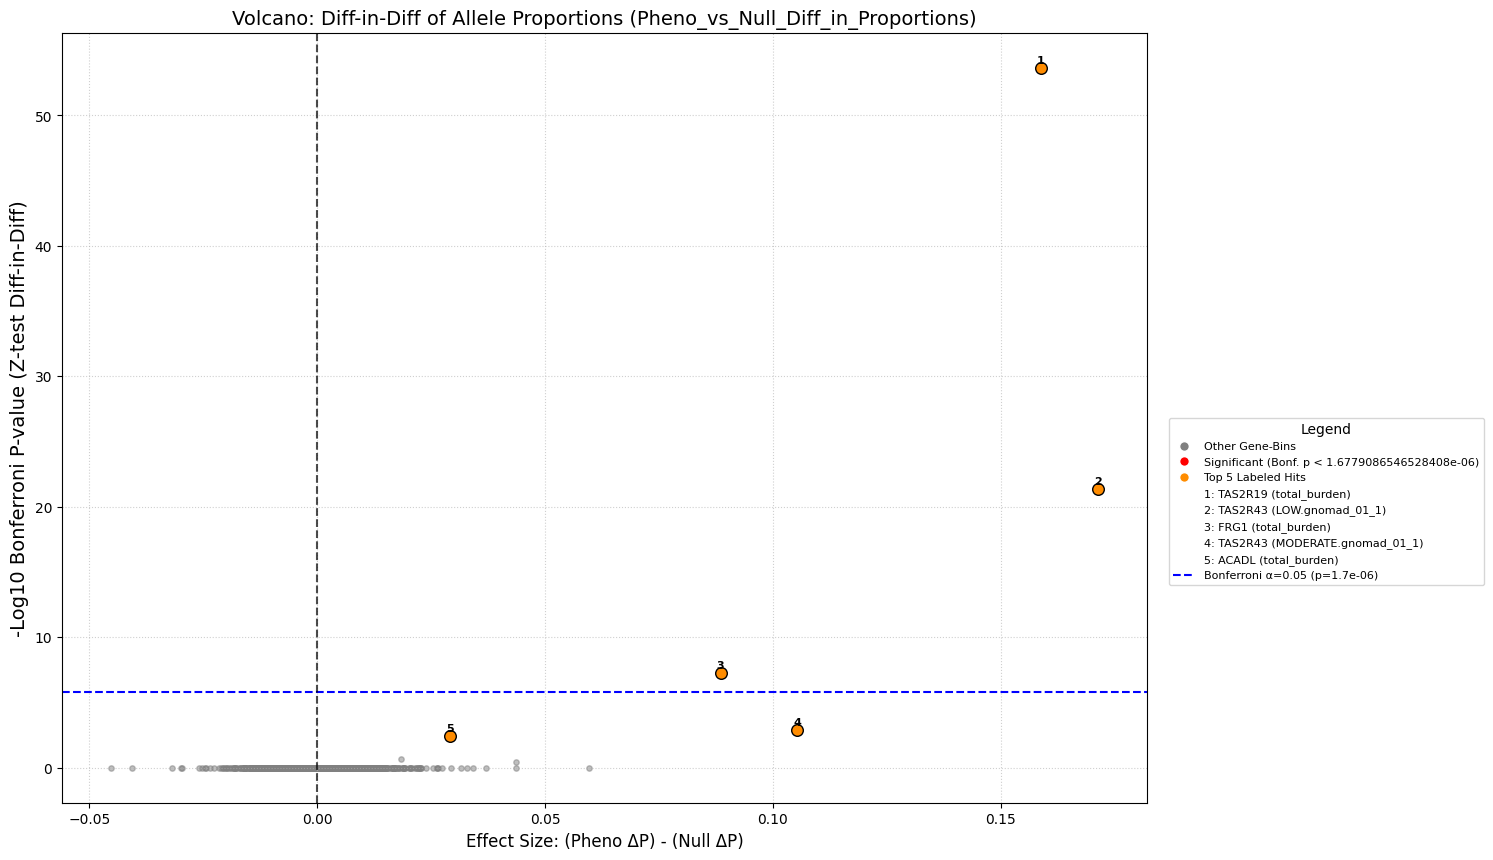


--- Top significant gene-bin differences (Pheno vs Null comparison) with Raw Allele Counts ---
          gene                   bin  effect_size_diff_of_diffs    z_score  \
26266  TAS2R19          total_burden                   0.158789  16.176126   
26280  TAS2R43       LOW.gnomad_01_1                   0.171270  10.666301   
10003     FRG1          total_burden                   0.088530   7.053174   
26277  TAS2R43  MODERATE.gnomad_01_1                   0.105325   5.472174   
372      ACADL          total_burden                   0.029253   5.291493   

              p_val  pval_bonferroni  -log10_pval_bonferroni  ac_case_pheno  \
26266  7.432609e-59     2.214843e-54               53.654657           1299   
26280  1.463371e-26     4.360698e-22               21.360444           1129   
10003  1.748816e-12     5.211298e-08                7.283054           1206   
26277  4.445469e-08     1.324705e-03                2.877881            913   
372    1.213221e-07     3.615277e-03    

In [114]:
# Make sure bin_columns is a list of strings if it's currently a pandas Index
current_bin_columns_list = bin_columns.tolist() if isinstance(bin_columns, pd.Index) else bin_columns

results_diff_in_diff_df = run_ztest_diff_of_diffs_volcano(
    df_case_pheno=df_case,
    df_control_pheno=df_control,
    df_case_null=df_nullcase,
    df_control_null=df_nullcontrol,
    n_indiv_case_pheno=case_count,
    n_indiv_control_pheno=control_count,
    n_indiv_case_null=nullcase_count,
    n_indiv_control_null=nullcontrol_count,
    bin_columns_list=current_bin_columns_list,
    cohort_name="Pheno_vs_Null_Diff_in_Proportions",
    mac_threshold_gene_pheno=1, # Adjust as needed
    mac_threshold_gene_null=1   # Adjust as needed
)

if results_diff_in_diff_df is not None and not results_diff_in_diff_df.empty:
    print("\n--- Top significant gene-bin differences (Pheno vs Null comparison) with Raw Allele Counts ---")
    
    # Filter for significant hits
    significant_hits_df = results_diff_in_diff_df[results_diff_in_diff_df['significant_bonferroni'] == True]
    
    if not significant_hits_df.empty:
        # Define the columns you want to see, including the raw counts
        columns_to_display = [
            'gene', 
            'bin', 
            'effect_size_diff_of_diffs', 
            'z_score', 
            'p_val', 
            'pval_bonferroni', 
            '-log10_pval_bonferroni',
            'ac_case_pheno',      # Raw allele count in phenotype positive set for this gene-bin
            'ac_control_pheno',   # Raw allele count in phenotype negative set for this gene-bin
            'ac_case_null',       # Raw allele count in null positive set for this gene-bin
            'ac_control_null'     # Raw allele count in null negative set for this gene-bin
        ]
        
        # Ensure all requested columns exist in the DataFrame to avoid KeyErrors
        existing_cols_to_display = [col for col in columns_to_display if col in significant_hits_df.columns]
        
        # Sort and display the top N hits
        top_significant_hits_with_counts = significant_hits_df[existing_cols_to_display].sort_values(
            by="-log10_pval_bonferroni", ascending=False
        ).head(20)
        
        print(top_significant_hits_with_counts)
    else:
        print("No significant hits found after Bonferroni correction.")
else:
    print("No results were generated from the Z-test function, or the results DataFrame is empty.")

### 5.3 Create volcano plot of significant single gene burdens

--- Starting Z-test for difference of log-odds ratios for cohort: Pheno_vs_Null_Diff_LogOR ---
Using 10 bin columns for analysis: ['HIGH.gnomad_001', 'HIGH.gnomad_001_01', 'HIGH.gnomad_01_1', 'MODERATE.gnomad_001', 'MODERATE.gnomad_001_01']...
DataFrame 'df_case_pheno' did not have 'gene' as index. Setting it now for local copy.
DataFrame 'df_control_pheno' did not have 'gene' as index. Setting it now for local copy.
DataFrame 'df_case_null' did not have 'gene' as index. Setting it now for local copy.
DataFrame 'df_control_null' did not have 'gene' as index. Setting it now for local copy.


/tmp/ipykernel_3799998/615905598.py:95: RuntimeWarning:

invalid value encountered in log

/tmp/ipykernel_3799998/615905598.py:163: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3799998/615905598.py:164: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe


Top 3 Labeled Gene-Bins (Numbered on Plot):
          gene                   bin  effect_size_diff_log_or    z_score  \
26278  TAS2R43       LOW.gnomad_01_1                 1.121554  10.208890   
10003     FRG1          total_burden                 1.038447   7.071302   
26275  TAS2R43  MODERATE.gnomad_01_1                 0.473550   5.428614   

              p_val  pval_bonferroni  ac_case_pheno  ac_control_pheno  \
26278  1.809220e-24     5.391114e-20           1129             13445   
10003  1.534867e-12     4.573598e-08           1206             14092   
26275  5.679341e-08     1.692330e-03            913             11380   

       ac_case_null  ac_control_null  
26278           925            13656  
10003          1093            14094  
26275           787            11502  


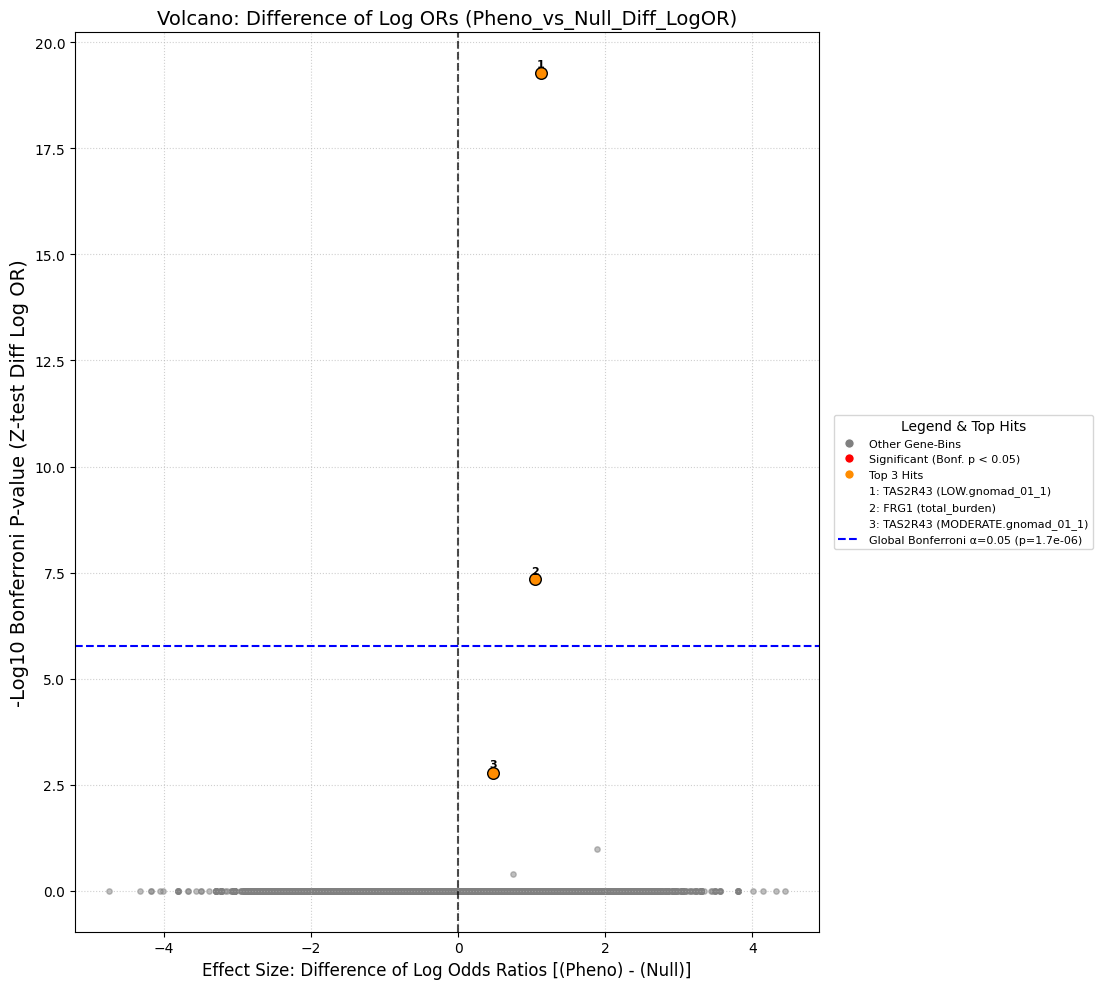


--- Top significant gene-bin differences (Pheno vs Null comparison - LogOR test) with Raw Allele Counts ---
          gene                   bin  effect_size_diff_log_or    z_score  \
26278  TAS2R43       LOW.gnomad_01_1                 1.121554  10.208890   
10003     FRG1          total_burden                 1.038447   7.071302   
26275  TAS2R43  MODERATE.gnomad_01_1                 0.473550   5.428614   

              p_val  pval_bonferroni  -log10_pval_bonferroni  ac_case_pheno  \
26278  1.809220e-24     5.391114e-20               19.268321           1129   
10003  1.534867e-12     4.573598e-08                7.339742           1206   
26275  5.679341e-08     1.692330e-03                2.771515            913   

       ac_control_pheno  ac_case_null  ac_control_null  
26278             13445           925            13656  
10003             14092          1093            14094  
26275             11380           787            11502  

--- Generating 2D Discovery Volcano Plot

/tmp/ipykernel_3799998/615905598.py:323: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





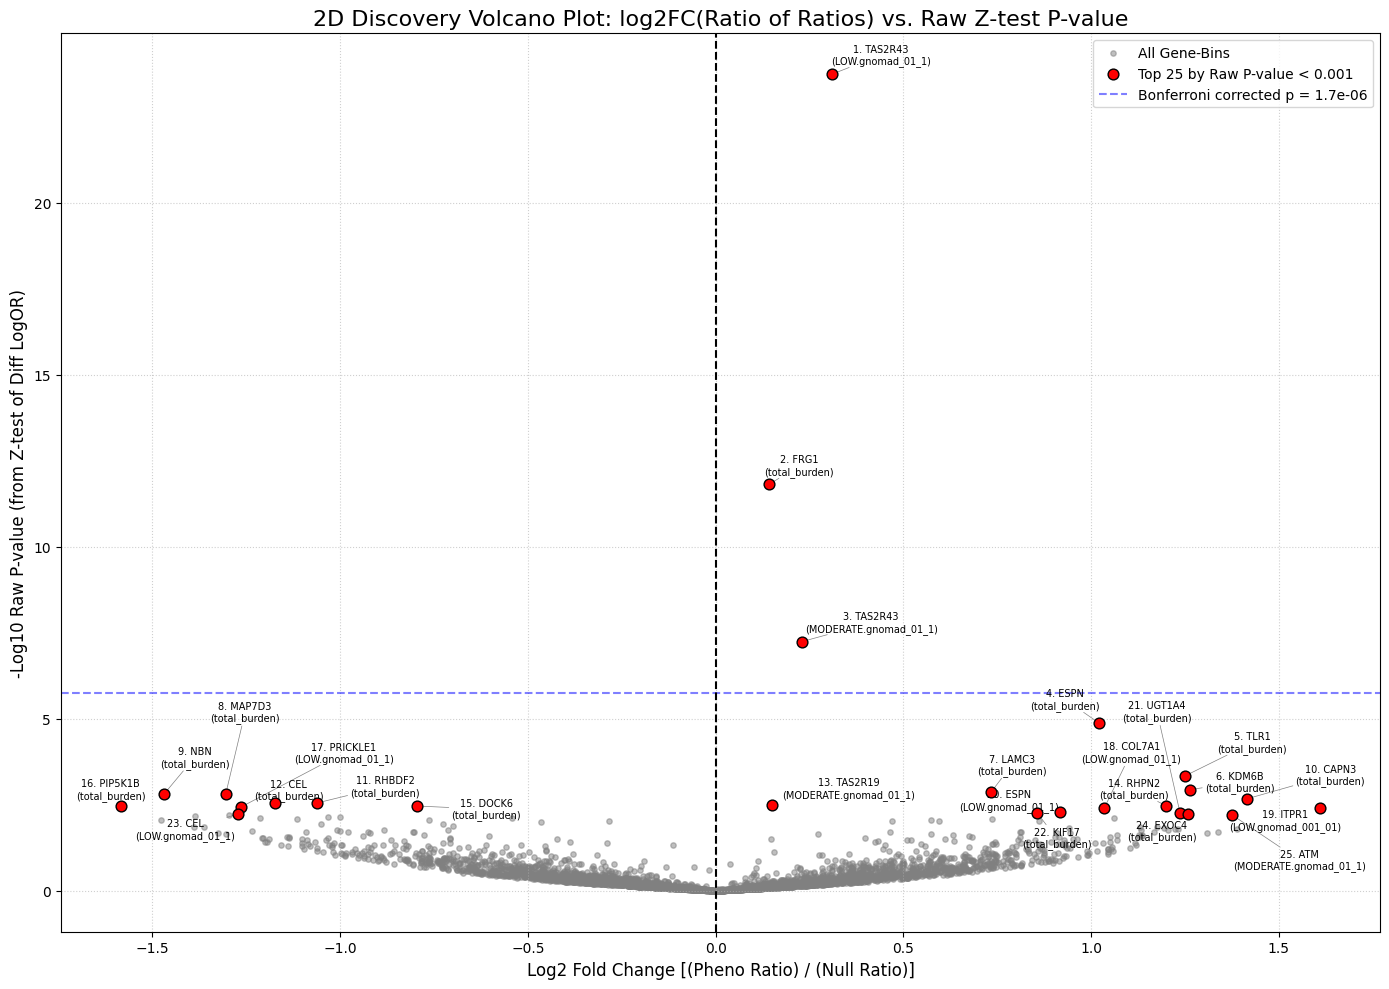

✅ 2D Discovery Volcano plot (log2FC vs Raw P-val) saved to /mnt/sdb/tmp3/iters_1000000_combs_10_case_639_control_9059/2d_discovery_volcano_log2fc_vs_raw_ztest_pval.png


<Figure size 640x480 with 0 Axes>

In [115]:
def run_ztest_diff_of_diffs_volcano(
    df_case_pheno, df_control_pheno, df_case_null, df_control_null,
    n_indiv_case_pheno, n_indiv_control_pheno, n_indiv_case_null, n_indiv_control_null,
    bin_columns_list, 
    cohort_name="Comparison",
    mac_threshold_gene_pheno=5, 
    mac_threshold_gene_null=5,  
    p_value_threshold_alpha=0.05 
):
    """
    Performs a Z-test for the difference of two log-odds ratios (comparing phenotype vs. null cohort)
    for each gene and bin, using Haldane-Anscombe correction for small counts.
    Generates a volcano plot and includes raw allele counts for significant hits.

    Args:
        df_case_pheno, df_control_pheno, df_case_null, df_control_null: DataFrames
            containing allele counts. These DataFrames should have 'gene' as their index
            and be aligned before calling this function. Columns include the bin names
            specified in bin_columns_list.
        n_indiv_case_pheno, ...: Number of diploid individuals in each of the four groups.
        bin_columns_list: List of bin column names to iterate over.
        cohort_name: Name for plot titles.
        mac_threshold_gene_pheno, mac_threshold_gene_null: Minimum sum of allele counts
            (case + control within the respective cohort) for a gene-bin to be included.
        p_value_threshold_alpha: Alpha level for significance.

    Returns:
        pd.DataFrame: DataFrame with Z-test results per gene-bin.
    """
    results = []
    print(f"--- Starting Z-test for difference of log-odds ratios for cohort: {cohort_name} ---")
    print(f"Using {len(bin_columns_list)} bin columns for analysis: {bin_columns_list[:5]}...")

    df_case_pheno_idx = df_case_pheno.copy()
    df_control_pheno_idx = df_control_pheno.copy()
    df_case_null_idx = df_case_null.copy()
    df_control_null_idx = df_control_null.copy()

    for df_name, df_check in [("df_case_pheno", df_case_pheno_idx), ("df_control_pheno", df_control_pheno_idx),
                              ("df_case_null", df_case_null_idx), ("df_control_null", df_control_null_idx)]:
        if df_check.index.name != 'gene':
            if 'gene' in df_check.columns:
                print(f"DataFrame '{df_name}' did not have 'gene' as index. Setting it now for local copy.")
                df_check.set_index('gene', inplace=True) 
            else:
                raise ValueError(f"DataFrame '{df_name}' must have 'gene' as its index or a 'gene' column to set as index.")

    raw_counts_data = [] 

    for gene_name in df_case_pheno_idx.index: 
        if not (gene_name in df_control_pheno_idx.index and \
                gene_name in df_case_null_idx.index and \
                gene_name in df_control_null_idx.index):
            continue

        for bin_base in bin_columns_list: 
            try:
                ac_case_pheno = df_case_pheno_idx.loc[gene_name, bin_base]
                ac_control_pheno = df_control_pheno_idx.loc[gene_name, bin_base]
                ac_case_null = df_case_null_idx.loc[gene_name, bin_base]
                ac_control_null = df_control_null_idx.loc[gene_name, bin_base]
            except KeyError:
                continue 
            
            raw_counts_data.append({
                'gene': gene_name,
                'bin': bin_base,
                'ac_case_pheno': ac_case_pheno,
                'ac_control_pheno': ac_control_pheno,
                'ac_case_null': ac_case_null,
                'ac_control_null': ac_control_null
            })

            if (ac_case_pheno + ac_control_pheno < mac_threshold_gene_pheno) or \
               (ac_case_null + ac_control_null < mac_threshold_gene_null):
                continue

            # Total alleles in each group
            n_alleles_case_pheno = 2 * n_indiv_case_pheno
            n_alleles_control_pheno = 2 * n_indiv_control_pheno
            n_alleles_case_null = 2 * n_indiv_case_null
            n_alleles_control_null = 2 * n_indiv_control_null
            
            if n_alleles_case_pheno == 0 or n_alleles_control_pheno == 0 or \
               n_alleles_case_null == 0 or n_alleles_control_null == 0:
                continue

            # --- Phenotype Cohort 2x2 Table (Haldane-Anscombe corrected) ---
            a_p = ac_case_pheno + 0.5
            b_p = (n_alleles_case_pheno - ac_case_pheno) + 0.5
            c_p = ac_control_pheno + 0.5
            d_p = (n_alleles_control_pheno - ac_control_pheno) + 0.5

            or_pheno = (a_p * d_p) / (b_p * c_p)
            log_or_pheno = np.log(or_pheno)
            se_log_or_pheno_sq = (1/a_p + 1/b_p + 1/c_p + 1/d_p)

            # --- Null Cohort 2x2 Table (Haldane-Anscombe corrected) ---
            a_n = ac_case_null + 0.5
            b_n = (n_alleles_case_null - ac_case_null) + 0.5
            c_n = ac_control_null + 0.5
            d_n = (n_alleles_control_null - ac_control_null) + 0.5

            or_null = (a_n * d_n) / (b_n * c_n)
            log_or_null = np.log(or_null)
            se_log_or_null_sq = (1/a_n + 1/b_n + 1/c_n + 1/d_n)

            # --- Test for difference between log_OR_pheno and log_OR_null ---
            diff_log_or = log_or_pheno - log_or_null
            se_diff_log_or_sq = se_log_or_pheno_sq + se_log_or_null_sq

            if se_diff_log_or_sq <= 1e-12: # Avoid division by zero or very small SE
                z_score = np.nan
                pval = np.nan
            else:
                se_diff_log_or = np.sqrt(se_diff_log_or_sq)
                z_score = diff_log_or / se_diff_log_or
                pval = 2 * norm.sf(np.abs(z_score)) 

            effect_size = diff_log_or # Effect size is the difference of log odds ratios
            
            results.append({
                'gene': gene_name, 
                'bin': bin_base,
                'log_or_pheno': log_or_pheno,
                'log_or_null': log_or_null,
                'effect_size_diff_log_or': effect_size,
                'z_score': z_score,
                'p_val': pval,
            })

    if not results:
        print("No results generated from Z-test after MAC filtering. Check MAC thresholds and data integrity.")
        return pd.DataFrame()

    results_df_all_genes = pd.DataFrame(results)
    results_df_all_genes.dropna(subset=['p_val'], inplace=True) 

    if results_df_all_genes.empty:
        print("No results with valid p-values after Z-test for any gene.")
        return results_df_all_genes
        
    if raw_counts_data:
        df_raw_counts = pd.DataFrame(raw_counts_data)
        results_df_all_genes = pd.merge(results_df_all_genes, df_raw_counts, on=['gene', 'bin'], how='left')
    else: 
        for col_name in ['ac_case_pheno', 'ac_control_pheno', 'ac_case_null', 'ac_control_null']:
            results_df_all_genes[col_name] = np.nan

    num_total_tests_performed_for_bonferroni = results_df_all_genes['p_val'].notna().sum()

    if 'p_val' in results_df_all_genes.columns and results_df_all_genes['p_val'].notna().any():
        pvals_to_correct = results_df_all_genes['p_val'].astype(float).dropna()
        if not pvals_to_correct.empty:
            reject_bonf, pval_bonferroni, bonf_alpha_corrected, _ = multipletests(pvals_to_correct, method='bonferroni', alpha=p_value_threshold_alpha)
            
            bonf_series = pd.Series(pval_bonferroni, index=results_df_all_genes['p_val'].dropna().index)
            reject_series = pd.Series(reject_bonf, index=results_df_all_genes['p_val'].dropna().index)

            results_df_all_genes['pval_bonferroni'] = bonf_series
            results_df_all_genes['significant_bonferroni'] = reject_series
            
            results_df_all_genes['pval_bonferroni'].fillna(1.0, inplace=True)
            results_df_all_genes['significant_bonferroni'].fillna(False, inplace=True)
            
            results_df_all_genes["-log10_pval_bonferroni"] = -np.log10(results_df_all_genes["pval_bonferroni"].astype(float).replace(0, np.nextafter(0, 1)))
        else:
            results_df_all_genes['pval_bonferroni'] = 1.0
            results_df_all_genes['significant_bonferroni'] = False
            results_df_all_genes["-log10_pval_bonferroni"] = 0.0
    else:
        results_df_all_genes['pval_bonferroni'] = 1.0
        results_df_all_genes['significant_bonferroni'] = False
        results_df_all_genes["-log10_pval_bonferroni"] = 0.0

    results_df_to_plot = results_df_all_genes 

    plt.figure(figsize=(14, 10)) 
    
    plt.scatter(results_df_to_plot["effect_size_diff_log_or"], 
                results_df_to_plot["-log10_pval_bonferroni"], 
                alpha=0.5, s=15, color='grey', label="Other Gene-Bins")

    significant_hits = results_df_to_plot[results_df_to_plot["significant_bonferroni"] == True]
    
    legend_handles_plot = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=7, label='Other Gene-Bins')]
    legend_labels_plot = ['Other Gene-Bins']

    if not significant_hits.empty:
        plt.scatter(significant_hits["effect_size_diff_log_or"], 
                    significant_hits["-log10_pval_bonferroni"], 
                    color="red", s=50, edgecolor='black', zorder=3, label=f'Significant (Bonf. p < {p_value_threshold_alpha})')
        legend_handles_plot.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label=f'Significant (Bonf. p < {p_value_threshold_alpha})'))
        legend_labels_plot.append(f'Significant (Bonf. p < {p_value_threshold_alpha})')

        top_n = 20
        top_hits_to_label = significant_hits.sort_values(
            by=["-log10_pval_bonferroni", "effect_size_diff_log_or"], 
            key=lambda x: x.abs() if x.name == "effect_size_diff_log_or" else x, 
            ascending=[False, False] 
        ).head(top_n)
        
        texts = []
        legend_entries_for_top_hits_list = [] 
        
        if not top_hits_to_label.empty:
            plt.scatter(top_hits_to_label["effect_size_diff_log_or"], 
                        top_hits_to_label["-log10_pval_bonferroni"], 
                        color="darkorange", s=70, edgecolor='black', zorder=5) 
            if f"Top {min(top_n, len(top_hits_to_label))} Hits" not in legend_labels_plot: 
                legend_handles_plot.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', markersize=7, label=f"Top {min(top_n, len(top_hits_to_label))} Hits"))
                legend_labels_plot.append(f"Top {min(top_n, len(top_hits_to_label))} Hits")

            for i, (_, row) in enumerate(top_hits_to_label.iterrows(), start=1):
                texts.append(plt.text(row["effect_size_diff_log_or"], 
                                      row["-log10_pval_bonferroni"], 
                                      str(i), fontsize=8, ha='center', va='bottom', fontweight='bold', zorder=6))
                legend_entries_for_top_hits_list.append(f"{i}: {row['gene']} ({row['bin']})")
            if texts:
                adjust_text(texts, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
            
            print(f"\nTop {len(legend_entries_for_top_hits_list)} Labeled Gene-Bins (Numbered on Plot):")
            cols_to_show = ['gene', 'bin', 'effect_size_diff_log_or', 'z_score', 'p_val', 'pval_bonferroni', 
                            'ac_case_pheno', 'ac_control_pheno', 'ac_case_null', 'ac_control_null']
            existing_cols_to_show = [col for col in cols_to_show if col in top_hits_to_label.columns]
            print(top_hits_to_label[existing_cols_to_show])
            
            for entry_text in legend_entries_for_top_hits_list:
                legend_handles_plot.append(plt.Line2D([0], [0], marker='None', linestyle='None')) 
                legend_labels_plot.append(entry_text)
    
    if num_total_tests_performed_for_bonferroni > 0:
        bonferroni_thresh_val_global = p_value_threshold_alpha / num_total_tests_performed_for_bonferroni
        log10_thresh_global = -np.log10(bonferroni_thresh_val_global)
        plt.axhline(log10_thresh_global, color='blue', linestyle='--') 
        if f'Bonferroni α={p_value_threshold_alpha}' not in legend_labels_plot:
             legend_handles_plot.append(plt.Line2D([0], [0], color='blue', linestyle='--'))
             legend_labels_plot.append(f'Global Bonferroni α={p_value_threshold_alpha} (p={bonferroni_thresh_val_global:.1e})')

    plt.axvline(0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel("Effect Size: Difference of Log Odds Ratios [(Pheno) - (Null)]", fontsize=12)
    plt.ylabel("-Log10 Bonferroni P-value (Z-test Diff Log OR)", fontsize=14)
    plt.title(f"Volcano: Difference of Log ORs ({cohort_name})", fontsize=14)
    plt.grid(True, linestyle=":", alpha=0.6)
    
    if legend_handles_plot:
        plt.legend(handles=legend_handles_plot, labels=legend_labels_plot, 
                   loc='center left', bbox_to_anchor=(1.02, 0.5), 
                   borderaxespad=0., title="Legend & Top Hits", fontsize=8)

    plt.tight_layout(rect=[0, 0, 0.80, 1]) 
    plt.show()


    return results_df_all_genes, bonf_alpha_corrected

# --- Example Call to the Z-test function ---
# Ensure df_case, df_control, df_nullcase, df_nullcontrol are defined
# (ideally the versions *before* add_epsilon if this test is on raw counts for proportions)
# and have 'gene' as index or a 'gene' column.
# Also bin_columns (as a list) and cohort counts should be defined.

# For this example, we'll use the _idx versions if they were created in dummy data,
# otherwise, we'll set the index on copies of the main dataframes.
# The function itself now makes copies and sets index, so passing df_case etc. is fine.

current_bin_columns_list = bin_columns.tolist() if isinstance(bin_columns, pd.Index) else bin_columns

results_diff_in_diff_df, bonf_alpha_corrected = run_ztest_diff_of_diffs_volcano(
    df_case_pheno=df_case,       # Pass the original df_case (before epsilon for this test)
    df_control_pheno=df_control,   
    df_case_null=df_nullcase,    
    df_control_null=df_nullcontrol,
    n_indiv_case_pheno=case_count,
    n_indiv_control_pheno=control_count,
    n_indiv_case_null=nullcase_count,
    n_indiv_control_null=nullcontrol_count,
    bin_columns_list=current_bin_columns_list, 
    cohort_name="Pheno_vs_Null_Diff_LogOR", 
    mac_threshold_gene_pheno=1, # Using 1 for dummy data, adjust for real data
    mac_threshold_gene_null=1,  # Using 1 for dummy data, adjust for real data
    p_value_threshold_alpha=0.05
)

if results_diff_in_diff_df is not None and not results_diff_in_diff_df.empty:
    print("\n--- Top significant gene-bin differences (Pheno vs Null comparison - LogOR test) with Raw Allele Counts ---")
    
    significant_hits_df = results_diff_in_diff_df[results_diff_in_diff_df['significant_bonferroni'] == True]
    
    if not significant_hits_df.empty:
        cols_to_display = ['gene', 'bin', 'effect_size_diff_log_or', 'z_score', 'p_val', 'pval_bonferroni', 
                           '-log10_pval_bonferroni',
                           'ac_case_pheno', 'ac_control_pheno', 'ac_case_null', 'ac_control_null']
        existing_cols_to_display = [col for col in cols_to_display if col in significant_hits_df.columns]
        
        top_significant_hits_with_counts = significant_hits_df[existing_cols_to_display].sort_values(
            by="-log10_pval_bonferroni", ascending=False
        ).head(20)
        
        print(top_significant_hits_with_counts)
    else:
        print("No significant hits found after Bonferroni correction from the Z-test of logOR differences.")
else:
    print("No results were generated from the Z-test function, or the results DataFrame is empty.")

if 'foldchange_df' in locals() and results_diff_in_diff_df is not None and not results_diff_in_diff_df.empty:
    print("\n--- Generating 2D Discovery Volcano Plot (log2_fold_change vs Raw P-value) ---")
    
    # Merge Z-test results (with raw p-values) with foldchange_df (for log2_fold_change from analyze_bins)
    discovery_plot_df_2d = pd.merge(
        results_diff_in_diff_df[['gene', 'bin', 'p_val']], # Select raw p_val from Z-test
        foldchange_df[['gene', 'bin', 'log2_fold_change']], # From analyze_bins output
        on=['gene', 'bin'],
        how='inner' # Only plot gene-bins present in both analyses
    )

    discovery_plot_df_2d.dropna(subset=['p_val', 'log2_fold_change'], inplace=True)
    
    if not discovery_plot_df_2d.empty:
        discovery_plot_df_2d["-log10_raw_pval"] = -np.log10(discovery_plot_df_2d["p_val"].astype(float)) # Use raw p_val

        # Replace inf/-inf that might come from log2_fold_change if ratios were extreme
        discovery_plot_df_2d['log2_fold_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        discovery_plot_df_2d.dropna(subset=['-log10_raw_pval', 'log2_fold_change'], inplace=True)

        if not discovery_plot_df_2d.empty:
            plt.figure(figsize=(14, 10))
            
            # Scatter all points
            plt.scatter(
                discovery_plot_df_2d["log2_fold_change"],
                discovery_plot_df_2d["-log10_raw_pval"],
                alpha=0.5, s=15, color='grey', label="All Gene-Bins"
            )

            # Highlight points passing a nominal raw p-value threshold (e.g., p < 0.001 for discovery)
            discovery_threshold_raw_p = 0.001 

            # Label top N hits based on raw p-value
            top_n_discovery_2d = 25 
            top_discovery_hits_2d = discovery_plot_df_2d.sort_values("-log10_raw_pval", ascending=False).head(top_n_discovery_2d)
            
            texts_2d = []
            if not top_discovery_hits_2d.empty:
                 plt.scatter( # Plot top hits again to ensure they are on top and potentially styled differently
                    top_discovery_hits_2d["log2_fold_change"],
                    top_discovery_hits_2d["-log10_raw_pval"],
                    color="red", s=60, edgecolor='black', zorder=5, label=f"Top {len(top_discovery_hits_2d)} by Raw P-value < {discovery_threshold_raw_p}"
                )
                 for i, (_, row) in enumerate(top_discovery_hits_2d.iterrows(), start=1):
                    texts_2d.append(plt.text(row["log2_fold_change"], 
                                           row["-log10_raw_pval"], 
                                           f"{i}. {row['gene']}\n({row['bin']})", # Label with number, gene, and bin
                                           fontsize=7, ha='center', va='bottom'))
                 if texts_2d:
                    adjust_text(texts_2d, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
            
            plt.axhline(-np.log10(bonf_alpha_corrected), color='blue', linestyle='--', alpha=0.5, label=f'Bonferroni corrected p = {bonf_alpha_corrected:.1e}')
            plt.axvline(0, color='black', linestyle='--')

            plt.xlabel("Log2 Fold Change [(Pheno Ratio) / (Null Ratio)]", fontsize=12)
            plt.ylabel("-Log10 Raw P-value (from Z-test of Diff LogOR)", fontsize=12)
            plt.title("2D Discovery Volcano Plot: log2FC(Ratio of Ratios) vs. Raw Z-test P-value", fontsize=16)
            plt.legend(loc='best')
            plt.grid(True, linestyle=":", alpha=0.6)
            plt.tight_layout()
            plt.show()
            if out_dir:
                 plt.savefig(out_dir / "2d_discovery_volcano_log2fc_vs_raw_ztest_pval.png", dpi=150)
                 print(f"✅ 2D Discovery Volcano plot (log2FC vs Raw P-val) saved to {out_dir / '2d_discovery_volcano_log2fc_vs_raw_ztest_pval.png'}")
        else:
            print("No data points remaining for 2D discovery plot after NaN removal.")
    else:
        print("Could not generate 2D discovery plot: 'foldchange_df' or 'results_diff_in_diff_df' is missing or empty.")

In [116]:
# Reset bin_columns based on the corrected df_case
bin_columns = df_case.columns[1:].tolist()

def add_epsilon(case, control, nullcase, nullcontrol):
    # Add a very small value epislon to all values (excluding 'gene') to avoid 0s in downstream ratios
    for df in [case, control, nullcase, nullcontrol]:
        df.iloc[:, 1:] = df.iloc[:, 1:].astype(float) + epsilon
    return case, control, nullcase, nullcontrol

In [117]:
foldchange_df[foldchange_df["gene"]=="ITIH6"]

,gene,bin,case_burden,control_burden,nullcase_burden,nullcontrol_burden,pheno_ratio,null_ratio,log2_fold_change


### 5.2 Calculating per cohort sumstats

In [118]:
def summarize_burden_totals(_cases, _controls, n_cases, n_controls, label="Phenotype"):
    """
    Summarize total burden counts (across all genes/frequency bins) between case and control cohorts.

    Returns:
        summary_dict: A dictionary of global summary statistics
    """
    expected_ratio = n_cases / n_controls

    # Total burden per individual (across all columns)
    case_totals = _cases["total_burden"]
    control_totals = _controls["total_burden"]

    # Group-level totals
    total_case_burden = case_totals.sum()
    total_control_burden = control_totals.sum()

    # Mean per sample
    case_mean = case_totals.mean()
    control_mean = control_totals.mean()
    case_median = case_totals.median()
    control_median = control_totals.median()
    case_std = case_totals.std()
    control_std = control_totals.std()

    # Ratios
    total_ratio = total_case_burden / total_control_burden
    log2_total_ratio = np.log2(total_ratio)
    mean_ratio = case_mean / control_mean
    log2_mean_ratio = np.log2(mean_ratio)

    # Print summary
    print(f"\n📊 Global Summary Statistics ({label})")
    print(f"Expected case/control size ratio: {expected_ratio:.3f} (log2: {np.log2(expected_ratio):.3f})")
    print(f"Observed total burden ratio: {total_ratio:.3f} (log2: {log2_total_ratio:.3f})")
    print(f"Mean burden ratio: {mean_ratio:.3f} (log2: {log2_mean_ratio:.3f})")
    print(f"Total case burden: {total_case_burden:.1f}, Total control burden: {total_control_burden:.1f}")
    print(f"Per-sample burden - case: mean={case_mean:.2f}, median={case_median:.2f}, std={case_std:.2f}")
    print(f"Per-sample burden - control: mean={control_mean:.2f}, median={control_median:.2f}, std={control_std:.2f}")

    # Return as a dictionary or DataFrame if needed
    return {
        "Expected_Ratio": expected_ratio,
        "Log2_Expected_Ratio": np.log2(expected_ratio),
        "Total_Case_Burden": total_case_burden,
        "Total_Control_Burden": total_control_burden,
        "Total_Ratio": total_ratio,
        "Log2_Total_Ratio": log2_total_ratio,
        "Mean_Case_Burden": case_mean,
        "Mean_Control_Burden": control_mean,
        "Mean_Ratio": mean_ratio,
        "Log2_Mean_Ratio": log2_mean_ratio,
        "Case_Median": case_median,
        "Control_Median": control_median,
        "Case_Std": case_std,
        "Control_Std": control_std,
    }

In [119]:
def plot_lollipop_and_delta(summary_pheno, summary_null, metrics=None, log2_delta=True, out_dir=None):
    """
    Plot side-by-side lollipop (raw values) and delta (difference) plots.

    Parameters:
        summary_pheno (dict): Summary stats for phenotype.
        summary_null (dict): Summary stats for null.
        metrics (list): List of metrics to compare (keys in summary dicts).
        log2_delta (bool): Whether to plot log2 differences instead of raw.
        out_dir (Path or str): Optional path to save as HTML.
    """
    if metrics is None:
        # Find all shared keys
        metrics = list(set(summary_pheno.keys()) & set(summary_null.keys()))
        metrics.sort()  # For consistent order

    # Prepare data
    df = pd.DataFrame({
        "Metric": metrics,
        "Phenotype": [summary_pheno[m] for m in metrics],
        "Null": [summary_null[m] for m in metrics],
    })
    
    if log2_delta:
        df["Delta"] = np.log2(df["Phenotype"] / df["Null"])
        delta_label = "Log2(Pheno / Null)"
    else:
        df["Delta"] = df["Phenotype"] - df["Null"]
        delta_label = "Phenotype - Null"

    # Create subplots: 1 row per metric, 2 columns
    fig = make_subplots(
        rows=len(df),
        cols=2,
        shared_xaxes=False,
        shared_yaxes=False,
        vertical_spacing=0.05,  # Adjust vertical spacing within allowable range
        column_widths=[0.6, 0.4],
        subplot_titles=[
            f"{metric} - Raw Values" if i % 2 == 0 else f"{metric} - {delta_label}"
            for metric in df["Metric"] for i in range(2)
        ]
    )

    # Add plots row by row
    for i, row in df.iterrows():
        metric = row["Metric"]
        row_num = i + 1

        # Lollipop (phenotype vs null)
        fig.add_trace(go.Scatter(
            x=[row["Phenotype"], row["Null"]],
            y=[metric, metric],
            mode="lines+markers",
            line=dict(color="gray"),
            marker=dict(size=6),
            showlegend=False
        ), row=row_num, col=1)

        fig.add_trace(go.Scatter(
            x=[row["Phenotype"]],
            y=[metric],
            mode="markers+text",
            name="Phenotype",
            marker=dict(color="blue", size=6),  # Increase marker size
            text=["Phenotype"],
            textposition="top center",
            showlegend=(i == 0)
        ), row=row_num, col=1)

        fig.add_trace(go.Scatter(
            x=[row["Null"]],
            y=[metric],
            mode="markers+text",
            name="Null",
            marker=dict(color="red", size=6),  # Increase marker size
            text=["Null"],
            textposition="top center",
            showlegend=(i == 0)
        ), row=row_num, col=1)

        # Delta
        fig.add_trace(go.Bar(
            x=[row["Delta"]],
            y=[metric],
            orientation="h",
            marker_color="blue" if row["Delta"] > 0 else "red",
            name="Δ",
            showlegend=False
        ), row=row_num, col=2)

    # Layout tweaks
    fig.update_layout(
        height=100 * len(df) + 300,  # Increase height for more separation
        width=1000,
        title="Metric-wise Lollipop + Delta Plot",
        xaxis_title="Raw Values",
        xaxis2_title=delta_label,
        margin=dict(l=100),
    )

    # Center delta plots at 0 and use the same scale
    max_delta = max(abs(df["Delta"].min()), abs(df["Delta"].max()))
    for i in range(1, len(df) + 1):
        fig.update_xaxes(range=[-max_delta, max_delta], row=i, col=2)

    # Save or show
    if out_dir:
        out_path = pathlib.Path(out_dir) / "lollipop_delta_per_metric.html"
        fig.write_html(str(out_path))
        print(f"✅ Plot saved to: {out_path}")
    else:
        fig.show()


In [120]:
# For your real phenotype data:
summary_pheno = summarize_burden_totals(df_case, df_control, case_count, control_count, label="Phenotype")
print(summary_pheno, 2)
# For your null data (assuming df_nullcase, df_nullcontrol are same shape as phenotype):
summary_null = summarize_burden_totals(df_nullcase, df_nullcontrol, nullcase_count, nullcontrol_count, label="Null")
print(summary_null, 2)

summary_pheno = {k: np.round(v, 4) for k, v in summary_pheno.items()}
summary_null = {k: np.round(v, 4) for k, v in summary_null.items()}
plot_lollipop_and_delta(summary_pheno, summary_null)
df_case.head()


📊 Global Summary Statistics (Phenotype)
Expected case/control size ratio: 0.071 (log2: -3.825)
Observed total burden ratio: 0.072 (log2: -3.790)
Mean burden ratio: 0.072 (log2: -3.790)
Total case burden: 84284.0, Total control burden: 1166179.0
Per-sample burden - case: mean=19.92, median=11.00, std=66.81
Per-sample burden - control: mean=275.63, median=153.00, std=834.72
{'Expected_Ratio': 0.07053758693012474, 'Log2_Expected_Ratio': -3.825463967334762, 'Total_Case_Burden': 84284, 'Total_Control_Burden': 1166179, 'Total_Ratio': 0.07227363895251072, 'Log2_Total_Ratio': -3.7903866544563773, 'Mean_Case_Burden': 19.920586149846372, 'Mean_Control_Burden': 275.6272748759159, 'Mean_Ratio': 0.07227363895251071, 'Log2_Mean_Ratio': -3.790386654456378, 'Case_Median': 11.0, 'Control_Median': 153.0, 'Case_Std': 66.81442370033675, 'Control_Std': 834.7227185329878} 2

📊 Global Summary Statistics (Null)
Expected case/control size ratio: 0.071 (log2: -3.825)
Observed total burden ratio: 0.072 (log2: -

,gene,HIGH.gnomad_001,HIGH.gnomad_001_01,HIGH.gnomad_01_1,MODERATE.gnomad_001,MODERATE.gnomad_001_01,MODERATE.gnomad_01_1,LOW.gnomad_001,LOW.gnomad_001_01,LOW.gnomad_01_1,total_burden
0,A2M,0,0,0,2,2,7,2,0,2,15
1,A4GALT,0,0,0,0,4,0,2,1,0,7
2,A4GNT,0,0,4,0,3,6,0,0,6,19
3,AAAS,0,0,0,0,0,3,0,0,0,3
4,AADAC,0,0,8,1,1,7,0,0,0,17


### 5.3 Random selection of indices for Monte Carlo permutation of genesets

In [121]:
def generate_sample_indices(
    iterations: int,
    combination_length: int,
    n_rows: int = None,
    sample_from_indices: np.ndarray = None,
    seed: int = 12345
):
    """
    Generates random index combinations.

    Can sample from a range (0 to n_rows-1) OR from a specific array of indices.
    """
    if n_rows is None and sample_from_indices is None:
        raise ValueError("Must provide either n_rows or sample_from_indices.")

    rng = np.random.default_rng(seed)
    
    # Determine the population to sample from
    population = np.arange(n_rows) if sample_from_indices is None else sample_from_indices
    
    if combination_length > len(population):
        raise ValueError("Combination length cannot be larger than the population size.")

    return np.array([
        rng.choice(population, size=combination_length, replace=False)
        for _ in range(iterations)
    ])

In [122]:
# Assume 'df_case' is your main dataframe (can be sorted alphabetically, it no longer matters)
# Assume 'nmd_gene_list' is your predefined list of NMD-related gene symbols

# --- For the NULL distribution (sampling from ALL genes) ---
# This remains the same and was always correct.
null_indices = generate_sample_indices(
    n_rows=len(df_case),
    combination_length=combination_length,
    iterations=iterations
)
print(f"Generated {null_indices.shape} sets for the null distribution.")


# --- For the NMD-Pheno distribution (sampling ONLY from NMD genes) ---
# THIS IS THE CORRECTED, UNBIASED PROCESS

# 1. Get the TRUE indices of the NMD genes from the main df_case
nmd_gene_true_indices = df_case[df_case['gene'].isin(nmd_gene_list)].index.to_numpy()

print(f"\nFound {len(nmd_gene_true_indices)} NMD-related genes to sample from.")
# This array will contain a mix of low and high numbers, e.g., [0, 1, 500, 4480, ...]

# 2. Generate the NMD-specific simulation sets by sampling from these true indices
nmd_simulation_indices = generate_sample_indices(
    sample_from_indices=nmd_gene_true_indices, # Pass the specific indices here
    combination_length=combination_length,
    iterations=iterations
)
print(f"Generated {nmd_simulation_indices.shape} sets for the NMD-pheno distribution.")

# Now, when you use this corrected `nmd_simulation_indices` in your analysis functions,
# the results will be free of alphabetical bias.

Generated (1000000, 10) sets for the null distribution.

Found 170 NMD-related genes to sample from.
Generated (1000000, 10) sets for the NMD-pheno distribution.


### 5.4 Ratios vector for each column based on given condition to include sum

### 5.5 Satisfying the following condition to get burden events
Low variant count events are not statistically significants.
I.e. gene sets containing only a few variants or variants in only one gene are excluded.
High variant burdens are expected between impactful genes in the different groups.



1. $$ \log_2\left(\frac{\text{ratios\_vector}}{\text{expected\_ratio}}\right) > log2(99th\_percentile) $$


2. $$ \text{total\_variants\_case} > \text{case\_genes\_length} $$


3. $$ \text{total\_variants\_control} > \text{case\_genes\_length} $$

4. $$ \text{ Nonzero values total\_variants\_control} > 1 $$

5. $$ \text{ Nonzero values total\_variants\_case} > 1 $$


In [123]:
def run_burden_simulation(
    df_case_like,
    df_control_like,
    bin_columns,
    indices,
    min_burden_per_sim=0,
    max_zero_or_nan=case_genes_length
):
    """
    Simulate burden ratios per frequency bin using predefined gene set indices.
    QC filtering is done per bin.
    """
    case_array = df_case_like[bin_columns].to_numpy()
    control_array = df_control_like[bin_columns].to_numpy()

    t_case_matrix = np.zeros((len(indices), len(bin_columns)))
    t_control_matrix = np.zeros((len(indices), len(bin_columns)))
    ratios_matrix = np.full((len(indices), len(bin_columns)), np.nan)

    for bin_idx in range(len(bin_columns)):
        case_bin_values = case_array[:, bin_idx]
        control_bin_values = control_array[:, bin_idx]

        case_sums = np.array([case_bin_values[idx].sum() for idx in indices])
        control_sums = np.array([control_bin_values[idx].sum() for idx in indices])

        t_case_matrix[:, bin_idx] = case_sums
        t_control_matrix[:, bin_idx] = control_sums

        # filter out values that equal n * epsilon (if epsilon > 0), otherwise just don't divide by 0
        # filtered rows default to np.nan
        ratios = np.divide(
            case_sums, control_sums,
            out=np.full_like(case_sums, np.nan, dtype=float),
            where=(control_sums != 0) | (control_sums != epsilon*(combination_length-max_zero_or_nan)) 
        )
        ratios_matrix[:, bin_idx] = ratios

    # QC filtering
    case_mean_burden = t_case_matrix
    control_mean_burden = t_control_matrix

    avg_burden_ok = (case_mean_burden > min_burden_per_sim) & (control_mean_burden > min_burden_per_sim)

    non_contributing = np.isnan(ratios_matrix)
    sparse_mask = non_contributing  # per bin sparse detection

    # Final mask: good average burden & not sparse
    valid_mask = avg_burden_ok & (~sparse_mask)
    #valid_mask = avg_burden_ok
    
    # Logging
    total_tests = len(indices) * len(bin_columns)
    retained_tests = np.sum(valid_mask, axis=0)

    print(f"\n🧪 QC Filtering Summary (Per Bin):")
    print(f"  Total simulation-bins: {total_tests}")
    print(f"  Good average burden: {np.sum(avg_burden_ok, axis=0)}; too sparse: {np.sum(sparse_mask, axis=0)}")
    print(f"  Retained: {np.sum(retained_tests)} ({(np.sum(retained_tests) / total_tests) * 100:.2f}%)\n")
    
    return ratios_matrix, t_case_matrix, t_control_matrix, valid_mask

In [136]:
# Add epsilon value now that summary stats are done
df_case, df_control, df_nullcase, df_nullcontrol = add_epsilon(df_case, df_control, df_nullcase, df_nullcontrol)

# Run both simulations
ratios_pheno, t_case_pheno, t_control_pheno, mask_pheno = run_burden_simulation(
    df_case, df_control, bin_columns, null_indices,
    min_burden_per_sim=min_burden_per_bin,
    max_zero_or_nan=combination_length)


ratios_null, t_case_null, t_control_null, mask_null = run_burden_simulation(
    df_nullcase, df_nullcontrol, bin_columns, null_indices,
    min_burden_per_sim=min_burden_per_bin,
    max_zero_or_nan=combination_length)

# Apply combined mask
#combined_mask = mask_pheno & mask_null

# Filter all arrays accordingly
ratios_pheno_masked = np.where(mask_pheno, ratios_pheno, np.nan)
ratios_null_masked = np.where(mask_null, ratios_null, np.nan)



# --- NMD Gene Set Specific Analysis ---
print("\n--- Starting NMD Gene Set Specific Analysis (Corrected Method) ---")
simulate_nmd = True

if not nmd_gene_list:
    print("⚠️ NMD_genes list is empty. Skipping NMD-specific analysis.")
    simulate_nmd = False
else:
    print(f"Found {len(nmd_gene_list)} NMD genes in config.")

    # STEP 1: Get the TRUE indices of NMD genes from the original, full DataFrame.
    # DO NOT reset the index. We need the original locations.
    nmd_gene_true_indices = df_case[df_case['gene'].isin(nmd_gene_list)].index.to_numpy()

    if nmd_gene_true_indices.size == 0:
        print("⚠️ No NMD genes found in the main dataframe. Skipping NMD simulation.")
        simulate_nmd = False
    else:
        print(f"Found {len(nmd_gene_true_indices)} NMD genes in the main dataframe to sample from.")

        effective_nmd_combination_length = min(len(nmd_gene_true_indices), combination_length)
        
        # STEP 2: Generate indices by sampling FROM the array of TRUE indices.
        nmd_simulation_indices = generate_sample_indices(
            sample_from_indices=nmd_gene_true_indices, # Use the special argument
            combination_length=effective_nmd_combination_length,
            iterations=iterations,
        )

        if nmd_simulation_indices.size == 0:
            print("⚠️ Failed to generate NMD-specific simulation indices.")
        else:
            print(f"Generated {len(nmd_simulation_indices)} unbiased NMD-specific gene sets.")
            
            # STEP 3: Run the simulation using the FULL DataFrames and the TRUE indices.
            # The function will now correctly "reach into" the full dataframe and
            # pull out the NMD genes, no matter where they are located.
            print("\n🔬 Running NMD-Specific Burden Simulation (using FULL dataframes and TRUE indices)...")
            ratios_nmd_pheno, t_case_nmd_pheno, t_control_nmd_pheno, mask_nmd_pheno = run_burden_simulation(
                df_case, df_control, bin_columns, nmd_simulation_indices, # Pass FULL dfs
                min_burden_per_sim=min_burden_per_bin,
                max_zero_or_nan=effective_nmd_combination_length
            )

            ratios_nmd_null, t_case_nmd_null, t_control_nmd_null, mask_nmd_null = run_burden_simulation(
                df_nullcase, df_nullcontrol, bin_columns, nmd_simulation_indices, # Pass FULL dfs
                min_burden_per_sim=min_burden_per_bin,
                max_zero_or_nan=effective_nmd_combination_length
            )

            # ... (your masking and analysis code follows) ...
            ratios_pheno_nmd_masked = np.where(mask_nmd_pheno, ratios_nmd_pheno, np.nan)
            ratios_null_nmd_masked = np.where(mask_nmd_null, ratios_nmd_null, np.nan)
            # Logging summary
            total_simulations = len(null_indices)*len(bin_columns)
            pheno_valid = mask_pheno.sum()
            null_valid = mask_null.sum()
            final_common = mask_pheno.sum()
            
            print(f"\n🎯 Final Simulation Filtering Summary:")
            print(f"  Total original simulations: {total_simulations}")
            print(f"  Retained in phenotype: {pheno_valid}")
            print(f"  Retained in null: {null_valid}")
            print(f"  ✅ Retained in BOTH: {final_common} ({(final_common / total_simulations) * 100:.2f}%)\n")
print("--- NMD Gene Set Specific Analysis Complete ---")


🧪 QC Filtering Summary (Per Bin):
  Total simulation-bins: 10000000
  Good average burden: [ 455914  455705  458839  999652  999861  999997  995943  999006  999978
 1000000]; too sparse: [0 0 0 0 0 0 0 0 0 0]
  Retained: 8364895 (83.65%)


🧪 QC Filtering Summary (Per Bin):
  Total simulation-bins: 10000000
  Good average burden: [ 494123  481332  475932  999724  999897  999999  996183  999100  999985
 1000000]; too sparse: [0 0 0 0 0 0 0 0 0 0]
  Retained: 8446275 (84.46%)


--- Starting NMD Gene Set Specific Analysis (Corrected Method) ---
Found 275 NMD genes in config.
Found 170 NMD genes in the main dataframe to sample from.
Generated 1000000 unbiased NMD-specific gene sets.

🔬 Running NMD-Specific Burden Simulation (using FULL dataframes and TRUE indices)...

🧪 QC Filtering Summary (Per Bin):
  Total simulation-bins: 10000000
  Good average burden: [ 462529  390248  529051  999985  999984 1000000  998938  999875  999999
 1000000]; too sparse: [0 0 0 0 0 0 0 0 0 0]
  Retained: 8380

In [137]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import firthlogist
import statsmodels.api as sm
from scipy.special import expit
import pandas as pd

results = []

for i, bin in enumerate(bin_columns):
    print(f"\n=== Bin {bin} ===")
    pheno_vals = ratios_pheno_masked[:, i]
    null_vals = ratios_null_masked[:, i]

    pheno_vals = pheno_vals[~np.isnan(pheno_vals)]
    null_vals = null_vals[~np.isnan(null_vals)]

    if len(pheno_vals) < 5 or len(null_vals) < 5:
        print(f"Skipping bin {bin} due to low data")
        continue

    # Prepare and scale data
    X_raw = np.concatenate([pheno_vals, null_vals]).reshape(-1, 1)
    y = np.hstack([np.ones(len(pheno_vals)), np.zeros(len(null_vals))])
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)

    # --- Firth Logistic Regression ---
    model_firth = firthlogist.FirthLogisticRegression(max_iter=100)
    model_firth.fit(X, y)
    
    log_odds = model_firth.coef_[0]
    se = model_firth.bse_[0]  # Standard error
    pval = model_firth.pvals_[0]
    
    odds_ratio = np.exp(log_odds)
    prob_change = expit(log_odds) - expit(0)
    
    # Confidence interval (log scale) → convert to log2
    log2_or = np.log2(odds_ratio)
    log2_se = se / np.log(2)
    ci_lower_log2 = log2_or - 1.96 * log2_se
    ci_upper_log2 = log2_or + 1.96 * log2_se

    print(f"Firth log-odds: {log_odds:.4f}, p = {pval:.2e}, OR = {odds_ratio:.3f}, Δprob = {prob_change:.4f}")
    print(f"95% CI log2(OR): {log2_or:.2f},[{ci_lower_log2:.3f}, {ci_upper_log2:.3f}]")

    # Save
    results.append({
        "bin": bin,
        "log_odds": log_odds,
        "se": se,
        "pval": pval,
        "odds_ratio": odds_ratio,
        "prob_change": prob_change,
        "log2_or": log2_or,
        "ci_lower_log2": ci_lower_log2,
        "ci_upper_log2": ci_upper_log2
    })

# Optional: convert to DataFrame
models_df = pd.DataFrame(results)


=== Bin HIGH.gnomad_001 ===
Firth log-odds: 0.1230, p = 0.00e+00, OR = 1.131, Δprob = 0.0307
95% CI log2(OR): 0.18,[0.171, 0.184]

=== Bin HIGH.gnomad_001_01 ===
Firth log-odds: -0.0406, p = 4.62e-85, OR = 0.960, Δprob = -0.0101
95% CI log2(OR): -0.06,[-0.064, -0.053]

=== Bin HIGH.gnomad_01_1 ===
Firth log-odds: -0.0564, p = 3.76e-161, OR = 0.945, Δprob = -0.0141
95% CI log2(OR): -0.08,[-0.087, -0.075]

=== Bin MODERATE.gnomad_001 ===
Firth log-odds: 0.0091, p = 1.49e-10, OR = 1.009, Δprob = 0.0023
95% CI log2(OR): 0.01,[0.009, 0.017]

=== Bin MODERATE.gnomad_001_01 ===
Firth log-odds: -0.0112, p = 2.73e-15, OR = 0.989, Δprob = -0.0028
95% CI log2(OR): -0.02,[-0.020, -0.012]

=== Bin MODERATE.gnomad_01_1 ===
Firth log-odds: 0.0212, p = 9.85e-51, OR = 1.021, Δprob = 0.0053
95% CI log2(OR): 0.03,[0.027, 0.035]

=== Bin LOW.gnomad_001 ===
Firth log-odds: 0.0368, p = 1.71e-148, OR = 1.037, Δprob = 0.0092
95% CI log2(OR): 0.05,[0.049, 0.057]

=== Bin LOW.gnomad_001_01 ===
Firth log-odds: 

/opt/global-venv/lib64/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log10



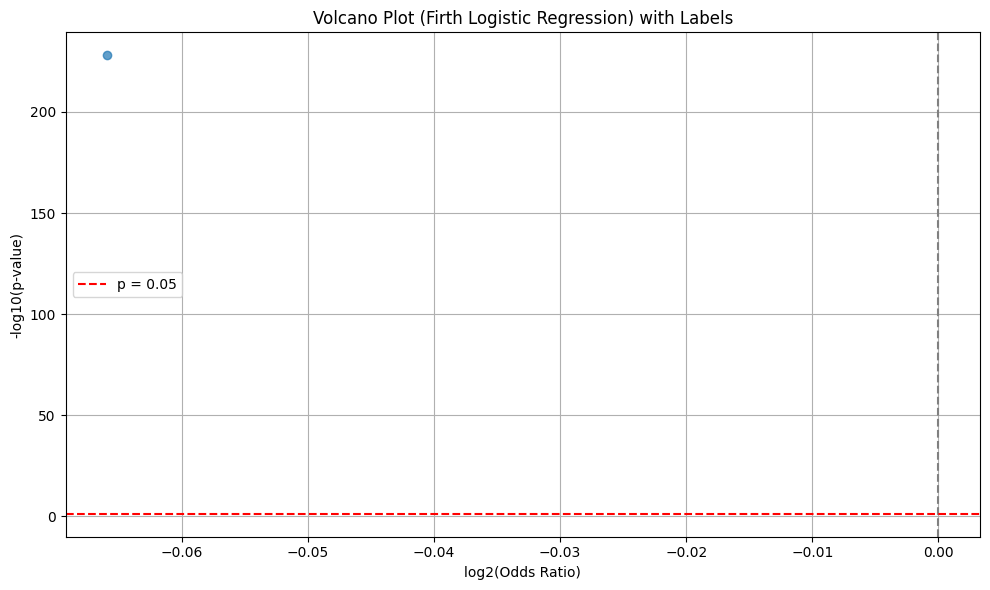

In [126]:
# Add labels to the volcano plot for selected points
import matplotlib.pyplot as plt

# Only label the most extreme points for clarity
# Define threshold for labeling
label_threshold = 4  # -log10(pval) > 4 (i.e., p < 1e-4)

plt.figure(figsize=(10, 6))
plt.scatter(models_df["log2_or"], -np.log10(models_df["pval"]), alpha=0.7)

# Draw guide lines
plt.axvline(x=0, color="gray", linestyle="--")
plt.axhline(y=-np.log10(0.05), color="red", linestyle="--", label="p = 0.05")

# Add labels for points with strong significance
for _, row in models_df.iterrows():
    if row["pval"] > label_threshold:
        plt.text(row["log2_odds_ratio"], row["pval"], row["bin"],
                 fontsize=8, ha='right', va='bottom')

plt.xlabel("log2(Odds Ratio)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot (Firth Logistic Regression) with Labels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [138]:
# Convert to DataFrames for easier manipulation and also normalize for expected ratio
df_ratios_pheno = pd.DataFrame(ratios_pheno_masked, columns=bin_columns).div(summary_pheno["Expected_Ratio"])
df_ratios_null = pd.DataFrame(ratios_null_masked, columns=bin_columns).div(summary_null["Expected_Ratio"])
if simulate_nmd:
    df_ratios_pheno_nmd = pd.DataFrame(ratios_pheno_nmd_masked, columns=bin_columns).div(summary_pheno["Expected_Ratio"])
    df_ratios_null_nmd = pd.DataFrame(ratios_null_nmd_masked, columns=bin_columns).div(summary_null["Expected_Ratio"])
    for col in bin_columns:
        df_ratios_pheno_nmd[col + "_log2"] = np.log2(df_ratios_pheno_nmd[col])
        df_ratios_null_nmd[col + "_log2"] = np.log2(df_ratios_null_nmd[col])
# Compute log2 transformed columns
for col in bin_columns:
    df_ratios_pheno[col + "_log2"] = np.log2(df_ratios_pheno[col])
    df_ratios_null[col + "_log2"] = np.log2(df_ratios_null[col])


In [139]:
# The empirical p-value from observed null vs phenotype simulation
# This would be the most exact (one-sided) interpretation of whether phenotype extreme positive burden differs from null group

from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

def calculate_empirical_p_values_onesided(df_pheno_vals, df_null_vals):
    # Dictionary to store p-values
    empirical_pvals_99th = {}
    
    for col in bin_columns:
        pheno_vals = df_pheno_vals[col + "_log2"].replace([np.inf, -np.inf], np.nan).dropna()
        null_vals = df_null_vals[col + "_log2"].replace([np.inf, -np.inf], np.nan).dropna()
    
        if len(pheno_vals) == 0 or len(null_vals) == 0:
            empirical_pvals_99th[col] = np.nan
            continue
    
        # Compute 99th percentile of phenotype distribution
        obs_99th = np.percentile(pheno_vals, 99)
    
        # One-sided empirical p-value: how many nulls exceed or equal obs_99th
        p_empirical = (np.sum(null_vals >= obs_99th) + 1) / (len(null_vals) + 1)
        print(f"{np.sum(null_vals >= obs_99th)} + 1 / {len(null_vals)} + 1")
        empirical_pvals_99th[col] = p_empirical
    
    # Assemble into DataFrame
    empirical_99th_df = pd.DataFrame({
        "Frequency_Bin": list(empirical_pvals_99th.keys()),
        "Empirical_Pval_99thPercentile": list(empirical_pvals_99th.values())
    })

    return empirical_99th_df

def bonferroni_correction(pvals_df1, pvals_df2):
    # Combine p-values from both dataframes
    combined_pvals = pvals_df1["Empirical_Pval_99thPercentile"].to_list() + \
                     pvals_df2["Empirical_Pval_99thPercentile"].to_list()
    
    # Apply Bonferroni correction
    reject, corrected_pvals, _, _ = multipletests(combined_pvals, alpha=0.05, method='bonferroni')
    
    # Split corrected values
    half = len(pvals_df1)
    pvals_df1["Bonferroni_Adjusted_Pval"] = corrected_pvals[:half]
    pvals_df1["Significant_p-val"] = reject[:half]
    pvals_df2["Bonferroni_Adjusted_Pval"] = corrected_pvals[half:]
    pvals_df2["Significant_p-val"] = reject[half:]
    
    return pvals_df1, pvals_df2

In [140]:
empirical_99th_df = calculate_empirical_p_values_onesided(df_ratios_pheno, df_ratios_null)
empirical_99th_nmd_df = calculate_empirical_p_values_onesided(df_ratios_pheno_nmd, df_ratios_null_nmd)
empirical_99th_df, empirical_99th_nmd_df = bonferroni_correction(empirical_99th_df, empirical_99th_nmd_df)

9453 + 1 / 494123 + 1
11564 + 1 / 481332 + 1
10583 + 1 / 475932 + 1
11046 + 1 / 999724 + 1
8761 + 1 / 999897 + 1
10646 + 1 / 999999 + 1
8497 + 1 / 996183 + 1
8351 + 1 / 999100 + 1
11558 + 1 / 999985 + 1
10449 + 1 / 1000000 + 1
2886 + 1 / 462484 + 1
7966 + 1 / 484568 + 1
2456 + 1 / 452544 + 1
1118 + 1 / 999889 + 1
14884 + 1 / 999986 + 1
15527 + 1 / 1000000 + 1
30566 + 1 / 999407 + 1
519 + 1 / 999663 + 1
4220 + 1 / 999998 + 1
1778 + 1 / 1000000 + 1


In [141]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# This plot compares the main Phenotype and Null simulations AND NMD-specific simulations
fig_overlay_main_sims = make_subplots(  # Renamed from fig_overlay_final to fig_overlay_main_sims for clarity
    rows=len(bin_columns),
    cols=1,
    vertical_spacing=0.03,
    subplot_titles = [
    f"{col}_log2 | Emp. P (Pheno 99th vs Null): Bonferroni_p={empirical_99th_df.loc[empirical_99th_df['Frequency_Bin'] == col, 'Bonferroni_Adjusted_Pval'].values[0]:.2f}"
        for col in bin_columns
    ]
)

for i, col in enumerate(bin_columns):
    col_log2_pheno = df_ratios_pheno.get(col + "_log2", pd.Series(dtype=float)).replace([np.inf, -np.inf],
                                                                                        np.nan).dropna()
    col_log2_null = df_ratios_null.get(col + "_log2", pd.Series(dtype=float)).replace([np.inf, -np.inf],
                                                                                      np.nan).dropna()

    # Get NMD data for this bin
    col_log2_pheno_nmd = df_ratios_pheno_nmd.get(col + "nmd_log2", pd.Series(dtype=float)).replace([np.inf, -np.inf],
                                                                                        np.nan).dropna()
    col_log2_null_nmd = df_ratios_null_nmd.get(col + "nmd_log2", pd.Series(dtype=float)).replace([np.inf, -np.inf],
                                                                                      np.nan).dropna()

    all_valid_data_for_bin = pd.concat(
        [col_log2_pheno, col_log2_null, col_log2_pheno_nmd, col_log2_null_nmd]).dropna()  # Include NMD data for range

    if len(all_valid_data_for_bin) > 1:
        min_val = all_valid_data_for_bin.min() - 1
        max_val = all_valid_data_for_bin.max() + 1
        x_grid = np.linspace(min_val, max_val, 500)

        # Plot Main Phenotype Simulation
        if len(col_log2_pheno) > 1:
            pheno_kde = gaussian_kde(col_log2_pheno)
            pheno_density = pheno_kde(x_grid)
            fig_overlay_main_sims.add_trace(
                go.Scattergl(x=x_grid, y=pheno_density, mode='lines', line=dict(color='red', width=2),
                             name="Phenotype (All Sets)", showlegend=(i == 0)),
                row=i + 1, col=1
            )

        # Plot Main Null Simulation
        if len(col_log2_null) > 1:
            null_kde = gaussian_kde(col_log2_null)
            null_density = null_kde(x_grid)
            fig_overlay_main_sims.add_trace(
                go.Scattergl(x=x_grid, y=null_density, mode='lines', line=dict(color='blue', width=2),
                             name="Null (All Sets)", showlegend=(i == 0)),
                row=i + 1, col=1
            )


        # Add Pheno 95th percentile line
        if len(col_log2_pheno) > 1:
            pheno_95th_val = np.percentile(col_log2_pheno, 99) #99th percentile
            fig_overlay_main_sims.add_vline(
            x=pheno_95th_val, line_width=1, line_dash="dot", line_color="red",
            row=i + 1, col=1)

            fig_overlay_main_sims.add_annotation(
                x=pheno_95th_val,
                y=0.1,  # Set this to a slightly higher value than the bottom of your y-axis
                text=f"Pheno 99th: {pheno_95th_val:.2f}",
                showarrow=False,
                xanchor="left",
                yanchor="bottom",
                font=dict(color="red"),
                row=i + 1,
                col=1
            )
    else:
        print(f"Skipping density plot for bin {col} due to insufficient combined data points after NaN removal.")

    fig_overlay_main_sims.update_xaxes(title_text="Log2 (Burden Ratio / Expected Cohort Ratio)", row=i + 1, col=1)
    fig_overlay_main_sims.update_yaxes(title_text="Density", row=i + 1, col=1)

fig_overlay_main_sims.update_layout(
    height=max(600, 250 * len(bin_columns)),
    width=1000,
    title_text=f"<b>Log2 Normalized Burden Ratio Distributions Comparison</b><br>(Phenotype vs. Null all genes) | N_iterations={iterations} | Geneset_size={combination_length}",
    hovermode="x unified",
    legend_title_text="Distribution Type",
    legend=dict(orientation="h",yanchor="bottom",y=-0.03,xanchor="center", x=0.5)
)
fig_overlay_main_sims.show()
if out_dir:
    fig_overlay_main_sims.write_html(out_dir.joinpath("Phenotype_Null_Log2_Density_Curves.html"))
    print(f"✅ Combined density plot saved to {out_dir.joinpath('Phenotype_Null_Log2_Density_Curves.html')}")



✅ Combined density plot saved to /mnt/sdb/tmp3/iters_1000000_combs_10_case_639_control_9059/Phenotype_Null_Log2_Density_Curves.html


In [142]:
# This plot compares the main Phenotype and Null simulations AND NMD-specific simulations
fig_overlay_main_sims = make_subplots(  # Renamed from fig_overlay_final to fig_overlay_main_sims for clarity
    rows=len(bin_columns),
    cols=1,
    vertical_spacing=0.03,
    subplot_titles = [
    f"{col}_log2 | Emp. P (Pheno 99th vs Null): Bonferroni_p={empirical_99th_nmd_df.loc[empirical_99th_nmd_df['Frequency_Bin'] == col, 'Bonferroni_Adjusted_Pval'].values[0]:.2f}"
        for col in bin_columns
    ]
)

for i, col in enumerate(bin_columns):

    # Get NMD data for this bin
    col_log2_pheno_nmd = df_ratios_pheno_nmd.get(col + "_log2", pd.Series(dtype=float)).replace([np.inf, -np.inf],
                                                                                        np.nan).dropna()
    col_log2_null_nmd = df_ratios_null_nmd.get(col + "_log2", pd.Series(dtype=float)).replace([np.inf, -np.inf],
                                                                                      np.nan).dropna()

    all_valid_data_for_bin = pd.concat(
        [col_log2_pheno_nmd, col_log2_null_nmd]).dropna()  # Include NMD data for range

    if len(all_valid_data_for_bin) > 1:
        min_val = all_valid_data_for_bin.min() - 1
        max_val = all_valid_data_for_bin.max() + 1
        x_grid = np.linspace(min_val, max_val, 500)

        # Plot NMD-Specific Pheno Simulation
        if len(col_log2_pheno_nmd) > 1:
            nmd_kde = gaussian_kde(col_log2_pheno_nmd)
            nmd_density = nmd_kde(x_grid)
            fig_overlay_main_sims.add_trace(
                go.Scattergl(x=x_grid, y=nmd_density, mode='lines', line=dict(color='red', dash='dash', width=2),
                             name="NMD Gene Sets (Pheno Data)", showlegend=(i == 0)),
                row=i + 1, col=1
            )

        # Plot NMD-Specific Null Simulation
        if len(col_log2_null_nmd) > 1:
            nmd_null_kde = gaussian_kde(col_log2_null_nmd)
            nmd_null_density = nmd_null_kde(x_grid)
            fig_overlay_main_sims.add_trace(
                go.Scattergl(x=x_grid, y=nmd_null_density, mode='lines', line=dict(color='blue', dash='dash', width=2),
                             name="NMD Gene Sets (Null Data)", showlegend=(i == 0)),
                row=i + 1, col=1
            )

        # Add Pheno 95th percentile line
        if len(col_log2_pheno_nmd) > 1:
            pheno_95th_val = np.percentile(col_log2_pheno_nmd, 99) #99th percentile
            fig_overlay_main_sims.add_vline(
            x=pheno_95th_val, line_width=1, line_dash="dot", line_color="red",
            row=i + 1, col=1)

            fig_overlay_main_sims.add_annotation(
                x=pheno_95th_val,
                y=0.1,  # Set this to a slightly higher value than the bottom of your y-axis
                text=f"Pheno 99th: {pheno_95th_val:.2f}",
                showarrow=False,
                xanchor="left",
                yanchor="bottom",
                font=dict(color="red"),
                row=i + 1,
                col=1
            )

    else:
        print(f"Skipping density plot for bin {col} due to insufficient combined data points after NaN removal.")

    fig_overlay_main_sims.update_xaxes(title_text="Log2 (Burden Ratio / Expected Cohort Ratio)", row=i + 1, col=1)
    fig_overlay_main_sims.update_yaxes(title_text="Density", row=i + 1, col=1)

fig_overlay_main_sims.update_layout(
    height=max(600, 250 * len(bin_columns)),
    width=1000,
    title_text=f"<b>Log2 Normalized Burden Ratio Distributions Comparison</b><br>(Phenotype vs. Null only NMD Gene Sets) | N_iterations={iterations} | Geneset_size={effective_nmd_combination_length}",
    hovermode="x unified",
    legend_title_text="Distribution Type",
    legend=dict(orientation="h",yanchor="bottom",y=-0.03,xanchor="center", x=0.5)
    )
fig_overlay_main_sims.show()
if out_dir:
    fig_overlay_main_sims.write_html(out_dir.joinpath("Phenotype_Null_NMD_Log2_Density_Curves.html"))
    print(f"✅ Combined density plot saved to {out_dir.joinpath('Phenotype_Null_NMD_Log2_Density_Curves.html')}")

✅ Combined density plot saved to /mnt/sdb/tmp3/iters_1000000_combs_10_case_639_control_9059/Phenotype_Null_NMD_Log2_Density_Curves.html


In [132]:
from collections import defaultdict


def get_top_contributing_nmd_genes(
    target_bin_name: str,
    df_ratios_nmd_pheno_log2: pd.DataFrame, # Should contain log2 transformed, normalized ratios for NMD sets on pheno data
    nmd_simulation_indices: np.ndarray,   # Maps simulation index to original df_case indices of NMD genes in that set
    df_case_with_epsilon: pd.DataFrame,   # Your df_case_eps, must contain 'gene' column and the target_bin_name
    percentile_threshold: float = 99.0
) -> pd.DataFrame:
    """
    Identifies top contributing NMD genes from simulated NMD gene sets
    that fall above a given percentile threshold for a specific bin.

    Args:
        target_bin_name: The specific bin column (e.g., "HIGH.gnomad_001_01") to analyze.
                         This should be the name *before* "_log2" is appended.
        df_ratios_nmd_pheno_log2: DataFrame of log2 normalized burden ratios for NMD gene sets.
                                  Columns are expected to be like f"{target_bin_name}_log2".
        nmd_simulation_indices: A 2D numpy array where each row contains the original indices
                                (from df_case_with_epsilon) of the NMD genes in that simulated set.
                                The row order must match df_ratios_nmd_pheno_log2.
        df_case_with_epsilon: The main case DataFrame (with epsilon applied) containing individual
                              gene burdens for each bin and a 'gene' column for symbols.
        percentile_threshold: The percentile to define "top offending sets".

    Returns:
        A pandas DataFrame with NMD genes ranked by their contribution,
        including frequency in top sets and total summed individual case burden in those sets.
        Returns an empty DataFrame if no top sets are found or data is insufficient.
    """
    print(f"\n--- Analyzing top contributing NMD genes for bin: {target_bin_name} ---")

    log2_bin_col_name = f"{target_bin_name}_log2"

    if log2_bin_col_name not in df_ratios_nmd_pheno_log2.columns:
        print(f"ERROR: Column '{log2_bin_col_name}' not found in df_ratios_nmd_pheno_log2.")
        return pd.DataFrame()

    if target_bin_name not in df_case_with_epsilon.columns:
        print(f"ERROR: Column '{target_bin_name}' not found in df_case_with_epsilon for individual burden lookup.")
        return pd.DataFrame()

    # Get the log2 ratios for NMD sets for the current bin
    nmd_ratios_for_bin = df_ratios_nmd_pheno_log2[log2_bin_col_name].dropna()

    if len(nmd_ratios_for_bin) < 20: # Need enough simulations for a stable percentile
        print(f"Warning: Insufficient valid NMD simulations for bin '{target_bin_name}' ({len(nmd_ratios_for_bin)} points) to reliably determine top contributors.")
        return pd.DataFrame()

    # Determine the threshold for top sets
    threshold_value = np.percentile(nmd_ratios_for_bin, percentile_threshold)
    print(f"Using >{percentile_threshold}th percentile threshold for '{log2_bin_col_name}': > {threshold_value:.4f}")

    # Identify indices of simulations that exceed this threshold
    # These indices correspond to rows in df_ratios_nmd_pheno_log2 and nmd_simulation_indices
    top_simulation_indices_df = nmd_ratios_for_bin[nmd_ratios_for_bin > threshold_value].index
    
    if len(top_simulation_indices_df) == 0:
        print(f"No NMD gene sets found above the {percentile_threshold}th percentile for bin '{target_bin_name}'.")
        return pd.DataFrame()
    
    print(f"Found {len(top_simulation_indices_df)} NMD gene sets above the threshold for bin '{target_bin_name}'.")

    # Aggregate statistics for genes in these top sets
    # Using defaultdict to easily accumulate counts and burdens
    # Key: gene_symbol, Value: dict {'appearance_count': int, 'total_individual_case_burden': float, 'avg_set_ratio_involved_in': list_of_floats}
    gene_contribution_stats = defaultdict(lambda: {'appearance_count': 0, 'total_individual_case_burden': 0.0, 'set_ratios_involved_in': []})

    for sim_idx in top_simulation_indices_df:
        if sim_idx >= len(nmd_simulation_indices):
            print(f"Warning: Simulation index {sim_idx} is out of bounds for nmd_simulation_indices. Skipping.")
            continue
            
        # Get the original DataFrame indices of genes in this top NMD set
        original_gene_indices_in_set = nmd_simulation_indices[sim_idx]
        set_burden_ratio = df_ratios_nmd_pheno_log2.loc[sim_idx, log2_bin_col_name]

        for gene_original_idx in original_gene_indices_in_set:
            if gene_original_idx >= len(df_case_with_epsilon):
                print(f"Warning: Gene index {gene_original_idx} from simulation {sim_idx} is out of bounds for df_case_with_epsilon. Skipping gene.")
                continue

            gene_symbol = df_case_with_epsilon.loc[gene_original_idx, 'gene']
            individual_case_burden = df_case_with_epsilon.loc[gene_original_idx, target_bin_name]

            gene_contribution_stats[gene_symbol]['appearance_count'] += 1
            gene_contribution_stats[gene_symbol]['total_individual_case_burden'] += individual_case_burden
            gene_contribution_stats[gene_symbol]['set_ratios_involved_in'].append(set_burden_ratio)
            
    if not gene_contribution_stats:
        print(f"No gene contributions could be tallied for bin '{target_bin_name}'.")
        return pd.DataFrame()

    # Convert to DataFrame for easier sorting and display
    results_list = []
    for gene, stats_dict in gene_contribution_stats.items():
        avg_set_ratio = np.mean(stats_dict['set_ratios_involved_in']) if stats_dict['set_ratios_involved_in'] else np.nan
        results_list.append({
            'gene': gene,
            'bin': target_bin_name,
            'appearance_in_top_sets': stats_dict['appearance_count'],
            'summed_indiv_case_burden_in_top_sets': stats_dict['total_individual_case_burden'] - (stats_dict['appearance_count'] * epsilon), # Subtract added epsilon
            'avg_log2_ratio_of_sets_involved_in': avg_set_ratio
        })
    
    ranked_genes_df = pd.DataFrame(results_list)
    
    # Sort by appearance count, then by summed individual burden
    ranked_genes_df.sort_values(by=['avg_log2_ratio_of_sets_involved_in', 'appearance_in_top_sets'], ascending=[False, False], inplace=True)
    
    return ranked_genes_df.reset_index(drop=True)

### 5.8 Transform the 99th percentiles into a dataframe

### 6.0 Plotting high burden events

Take in high value burden events and filter out genes from gene sets that actually contribute to the burden event,
keep only impactful (i.e. above 99th percentile) events and plot the times the gene has appeared in burden events against highest event, keep only genes that appear more than 40 times.

In [133]:
from itertools import combinations
from collections import Counter
import pandas as pd
import numpy as np

def analyze_gene_pair_cooccurrence(
    top_genes_df: pd.DataFrame,
    all_nmd_simulation_sets: np.ndarray,
    top_simulation_indices: np.ndarray,
    df_case_with_epsilon: pd.DataFrame,
    top_n_to_analyze: int = 20
) -> pd.DataFrame:
    """
    Analyzes the co-occurrence of top-contributing genes within the most
    significantly burdened gene sets.

    This serves as a proxy for an interaction analysis when only summary-level
    data is available, testing the hypothesis that interacting genes will
    cluster in high-burden pathways.

    Args:
        top_genes_df: DataFrame output from get_top_contributing_nmd_genes.
                      Must contain a 'gene' column.
        all_nmd_simulation_sets: The full 2D array of gene sets used for simulation,
                                 where values are original df_case indices.
                                 (This is your `nmd_simulation_indices` variable).
        top_simulation_indices: The indices of the simulations that were found
                                to be in the top percentile.
        df_case_with_epsilon: The main case DataFrame, used to map indices to gene symbols.
        top_n_to_analyze: The number of top genes from top_genes_df to include
                          in the co-occurrence analysis.

    Returns:
        A pandas DataFrame of gene pairs, ranked by how frequently they
        appear together in the top-burdened simulation sets.
    """
    print(f"\n--- Analyzing Co-occurrence for Top {top_n_to_analyze} Genes ---")
    if top_n_to_analyze > len(top_genes_df):
        print(f"Warning: Requested top {top_n_to_analyze} genes, but only {len(top_genes_df)} are available. Using all.")
        top_n_to_analyze = len(top_genes_df)
        
    # Get the set of gene symbols to focus on
    top_genes_set = set(top_genes_df['gene'].head(top_n_to_analyze))
    print(f"Focusing on the following genes: {', '.join(list(top_genes_set))}")

    # Map gene indices to gene symbols once to create a dictionary for fast lookup
    index_to_gene_map = df_case_with_epsilon['gene'].to_dict()
    
    # Filter to only the top-burdened simulation sets
    significant_pathway_indices = all_nmd_simulation_sets[top_simulation_indices]

    pair_counts = Counter()

    # Iterate through only the significant pathways
    for pathway_indices in significant_pathway_indices:
        # Convert indices to gene symbols for this pathway
        pathway_genes = {index_to_gene_map.get(idx) for idx in pathway_indices if index_to_gene_map.get(idx) is not None}
        
        # Find which of our top genes are in this specific significant pathway
        genes_of_interest_in_pathway = top_genes_set.intersection(pathway_genes)

        # If 2 or more of our top genes are in this pathway, count their pairs
        if len(genes_of_interest_in_pathway) >= 2:
            # Generate all unique pairs of these genes, sorted alphabetically
            for pair in combinations(sorted(list(genes_of_interest_in_pathway)), 2):
                pair_counts[pair] += 1

    if not pair_counts:
        print("No co-occurring pairs of top genes were found in the significant pathways.")
        return pd.DataFrame()

    # Convert the results to a sorted DataFrame
    interaction_df = pd.DataFrame(pair_counts.items(), columns=['gene_pair', 'co_occurrence_count'])
    interaction_df[['gene_1', 'gene_2']] = pd.DataFrame(interaction_df['gene_pair'].tolist(), index=interaction_df.index)
    
    # Sort by the most frequently occurring pairs
    ranked_interactions = interaction_df[['gene_1', 'gene_2', 'co_occurrence_count']].sort_values(
        by='co_occurrence_count', ascending=False
    ).reset_index(drop=True)
    
    return ranked_interactions

# Example:
interesting_bin = "MODERATE.gnomad_001" # e.g., "HIGH.gnomad_001_01" or any other bin reaching significance

# Check if necessary variables from your simulation run exist
if 'df_ratios_pheno_nmd' in locals() and not df_ratios_pheno_nmd.empty and \
   'nmd_simulation_indices' in locals() and nmd_simulation_indices.size > 0:

    # --- Part 1: Get Top Offending Genes (Your existing code) ---
    top_offending_genes_df = get_top_contributing_nmd_genes(
        target_bin_name=interesting_bin,
        df_ratios_nmd_pheno_log2=df_ratios_pheno_nmd,
        nmd_simulation_indices=nmd_simulation_indices,
        df_case_with_epsilon=df_case,
        percentile_threshold=99.0
    )

    if top_offending_genes_df is not None and not top_offending_genes_df.empty:
        print(f"\nTop offending NMD genes for bin '{interesting_bin}':")
        print(top_offending_genes_df.head(10))

        # --- Part 2: Analyze Co-occurrence (The new part) ---
        
        # We need the indices of the top simulations. We re-calculate them here briefly.
        # (This logic is inside get_top_contributing_nmd_genes, but we need the indices here)
        log2_bin_col = f"{interesting_bin}_log2"
        nmd_ratios_bin = df_ratios_pheno_nmd[log2_bin_col].dropna()
        threshold = np.percentile(nmd_ratios_bin, 99.0)
        top_sim_indices = nmd_ratios_bin[nmd_ratios_bin > threshold].index.to_numpy()

        if top_sim_indices.size > 0:
            # Now, find the interacting pairs among the top genes
            potential_interactions_df = analyze_gene_pair_cooccurrence(
                top_genes_df=top_offending_genes_df,
                all_nmd_simulation_sets=nmd_simulation_indices, # The full array of simulated sets
                top_simulation_indices=top_sim_indices,        # Just the indices of the top sets
                df_case_with_epsilon=df_case,
                top_n_to_analyze=25 # Analyze pairs within the top 25 offending genes
            )

            if potential_interactions_df is not None and not potential_interactions_df.empty:
                print("\n--- Potential Oligogenic Pairs (Ranked by Co-occurrence) ---")
                print(f"The following pairs of top genes most frequently appeared together in high-burden gene sets for bin '{interesting_bin}':")
                print(potential_interactions_df)
                # potential_interactions_df.to_csv(out_dir / f"interactions_{interesting_bin}.csv", index=False)

    else:
        print(f"No top offending NMD genes found or processed for bin '{interesting_bin}'.")
else:
    print("NMD-Pheno simulation results are not available to run analysis.")



--- Analyzing top contributing NMD genes for bin: MODERATE.gnomad_001 ---
Using >99.0th percentile threshold for 'MODERATE.gnomad_001_log2': > 1.0240
Found 9997 NMD gene sets above the threshold for bin 'MODERATE.gnomad_001'.

Top offending NMD genes for bin 'MODERATE.gnomad_001':
      gene                  bin  appearance_in_top_sets  \
0     MYF6  MODERATE.gnomad_001                    1085   
1  SLC25A4  MODERATE.gnomad_001                    1030   
2     MYOT  MODERATE.gnomad_001                    1341   
3      DES  MODERATE.gnomad_001                     912   
4    TNNI2  MODERATE.gnomad_001                    1108   
5    GFPT1  MODERATE.gnomad_001                    1318   
6     TPM2  MODERATE.gnomad_001                     775   
7   TSEN54  MODERATE.gnomad_001                     809   
8     ALG2  MODERATE.gnomad_001                    1010   
9    ACTA1  MODERATE.gnomad_001                    1043   

   summed_indiv_case_burden_in_top_sets  avg_log2_ratio_of_sets_inv

### 6.2  Plot relevant genes in network

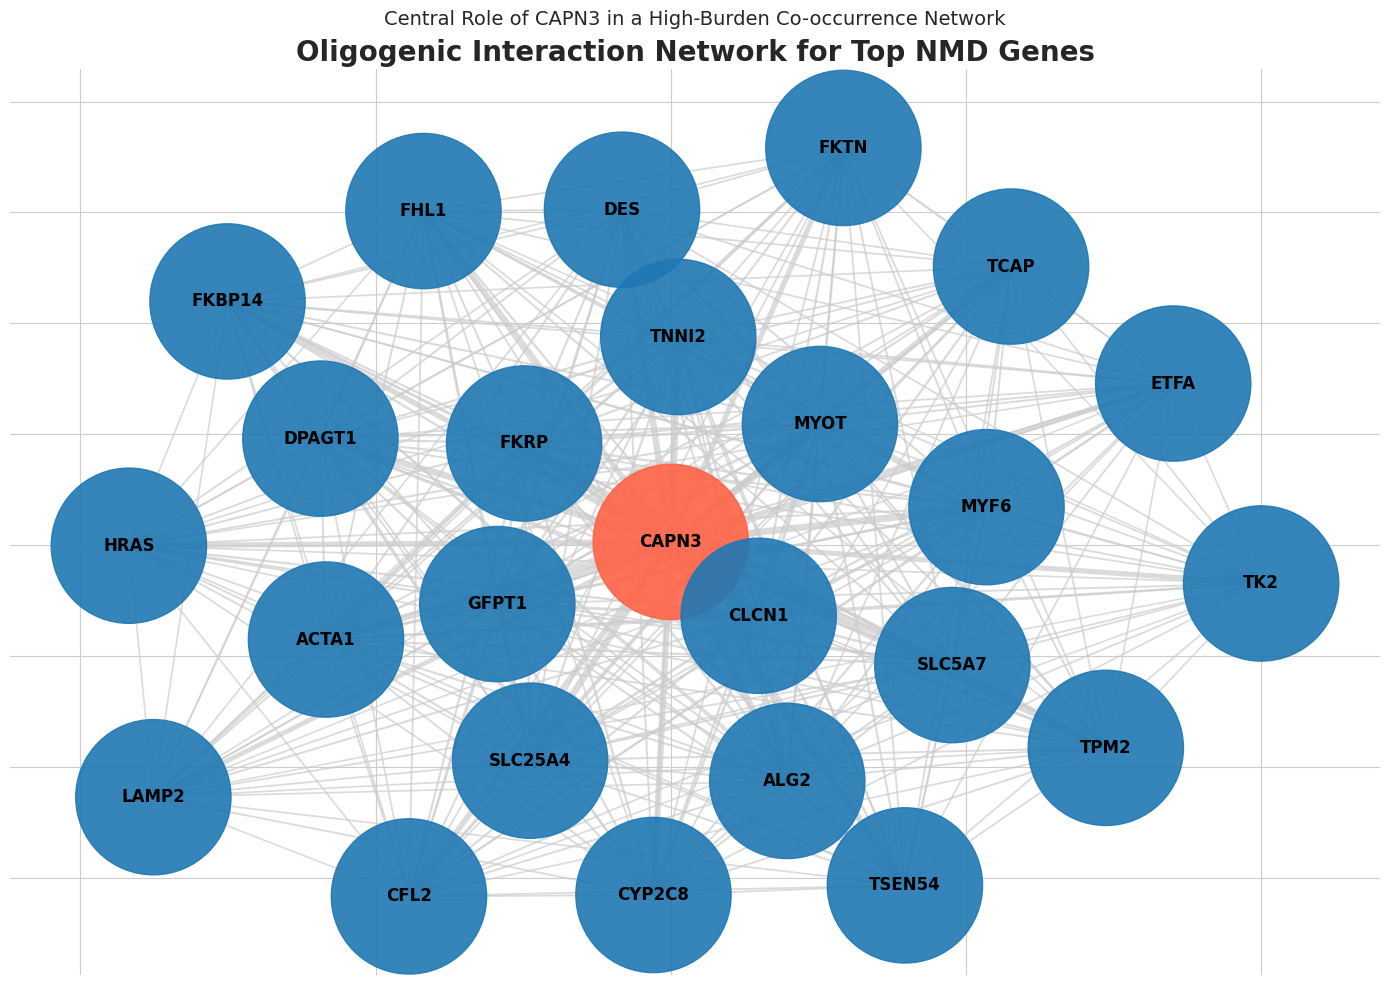

In [135]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_interaction_network(
    interaction_df: pd.DataFrame,
    hub_gene: str = 'CAPN3',
    title: str = 'Oligogenic Interaction Network for Top NMD Genes',
    subtitle: str = 'Central Role of a Hub Gene in a High-Burden Co-occurrence Network'
):
    """
    Generates and displays a network graph of gene co-occurrences.

    Args:
        interaction_df (pd.DataFrame): DataFrame with columns 'gene_1', 'gene_2',
                                       and 'co_occurrence_count'.
        hub_gene (str, optional): The gene to highlight as the central hub.
                                  Defaults to 'CAPN3'.
        title (str, optional): The main title for the plot.
        subtitle (str, optional): The subtitle for the plot.
    """
    if not all(col in interaction_df.columns for col in ['gene_1', 'gene_2', 'co_occurrence_count']):
        raise ValueError("interaction_df must contain 'gene_1', 'gene_2', and 'co_occurrence_count' columns.")

    # --- 1. Create the Graph from the DataFrame ---
    G = nx.Graph()
    for _, row in interaction_df.iterrows():
        G.add_edge(row['gene_1'], row['gene_2'], weight=row['co_occurrence_count'])

    # --- 2. Prepare for Visualization ---
    # Calculate node sizes based on degree (number of connections)
    degrees = dict(G.degree())
    node_sizes = [degrees.get(node, 1) * 500 + 500 for node in G.nodes()]

    # Assign colors to nodes: a different color for the hub gene
    node_colors = ['#ff6347' if node == hub_gene else '#1f78b4' for node in G.nodes()]

    # Set edge widths based on the co-occurrence count (weight)
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(weights) if weights else 1
    edge_widths = [1 + (w / max_weight) * 5 for w in weights] # Scale width from 1 to 6

    # Use a spring layout for aesthetically pleasing node placement
    pos = nx.spring_layout(G, k=1.5, iterations=50, seed=42)

    # --- 3. Draw the Network ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 10))

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='#cccccc', alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_family='sans-serif', ax=ax)

    # --- 4. Final Touches ---
    ax.set_title(title, fontsize=20, fontweight='bold')
    if subtitle:
        fig.suptitle(subtitle.replace('a Hub Gene', f'{hub_gene}'), fontsize=14)

    # Remove axes for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

    plt.tight_layout()
    plt.show()

if potential_interactions_df is not None and not potential_interactions_df.empty:
    plot_interaction_network(potential_interactions_df)